In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

%matplotlib inline

In [2]:
nes_df = pd.read_csv('../data/nes_data.csv', skiprows=1, names = [
    'year',
    'month',
    'zip',
    'customer_type',
    'monthly_kwh_used'
])
nes_df.head()

year  month                           zip     customer_type  \
0  2015.0     10  37219(36.167467, -86.783669)        COMMERCIAL   
1  2015.0      9  37213(36.167552, -86.767564)        COMMERCIAL   
2  2016.0      4                         37076  OUTDOOR LIGHTING   
3  2016.0      4                         37214        COMMERCIAL   
4  2016.0      1  37208(36.176427, -86.805176)        COMMERCIAL   

   monthly_kwh_used  
0          216867.0  
1          153407.0  
2               0.0  
3         1149364.0  
4          939818.0

In [3]:
nes_df['geometry'] = nes_df['zip'].str.extract(r'\((.*)\)')
nes_df['zip'] = nes_df['zip'].str.replace(r'\(.*\)', '')
nes_df.head()

year  month    zip     customer_type  monthly_kwh_used  \
0  2015.0     10  37219        COMMERCIAL          216867.0   
1  2015.0      9  37213        COMMERCIAL          153407.0   
2  2016.0      4  37076  OUTDOOR LIGHTING               0.0   
3  2016.0      4  37214        COMMERCIAL         1149364.0   
4  2016.0      1  37208        COMMERCIAL          939818.0   

                geometry  
0  36.167467, -86.783669  
1  36.167552, -86.767564  
2                    NaN  
3                    NaN  
4  36.176427, -86.805176

currently points are in (lat, lng) pairs

In [4]:
nes_df.loc[~nes_df.geometry.isnull(), 'geometry'] = \
    nes_df.loc[~nes_df.geometry.isnull()].geometry\
        .str.split(',')\
        .apply(lambda x: (float(x[1].strip()), float(x[0].strip())))\
        .apply(Point)

In [5]:
nes_df.head()

year  month    zip     customer_type  monthly_kwh_used  \
0  2015.0     10  37219        COMMERCIAL          216867.0   
1  2015.0      9  37213        COMMERCIAL          153407.0   
2  2016.0      4  37076  OUTDOOR LIGHTING               0.0   
3  2016.0      4  37214        COMMERCIAL         1149364.0   
4  2016.0      1  37208        COMMERCIAL          939818.0   

                               geometry  
0          POINT (-86.783669 36.167467)  
1  POINT (-86.76756399999999 36.167552)  
2                                   NaN  
3                                   NaN  
4          POINT (-86.805176 36.176427)

In [6]:
# only care about ones that have zips
nes_df = nes_df[~nes_df['zip'].isnull()]

# convert zips to int
nes_df['zip'] = nes_df['zip'].astype(int)

In [7]:
zip_codes_gpd = gpd.read_file('../data/zip_codes.geojson')
zip_codes_gpd.head()

zip objectid    po_name      shape_stlength        shape_starea  \
0  37027       34  BRENTWOOD   3140.581074908484  595244.46435546875   
1  37027       37  BRENTWOOD  3558.4949049555025  315672.26501464844   
2  37143       29     PEGRAM   7053.537934957626   1901096.087890625   
3  37143       28     PEGRAM  1197.1070870572601  83126.842468261719   
4  37240       44  NASHVILLE  9240.7969963306841  3146698.6988525391   

                                            geometry  
0  (POLYGON ((-86.684745973484 35.992792089723, -...  
1  (POLYGON ((-86.719974241412 36.009524281615, -...  
2  (POLYGON ((-87.03537311557 36.087623620297, -8...  
3  (POLYGON ((-87.03605109734001 36.095325458066,...  
4  (POLYGON ((-86.803254434485 36.149298486807, -...

In [8]:
zip_codes_gpd['centroid'] = zip_codes_gpd.geometry.centroid
zip_codes_gpd.zip = zip_codes_gpd.zip.astype(int)

In [9]:
print(nes_df.shape)
print(nes_df[nes_df['zip'].isin(zip_codes_gpd.zip.unique())].shape)

(12526, 6)
(10499, 6)


In [10]:
# Lets go ahead and drop the rows that aren't strictly nashville. 
nes_df = nes_df[nes_df['zip'].isin(zip_codes_gpd.zip.unique())]

In [11]:
nes_df.loc[nes_df.geometry.isnull(), 'geometry'] = \
    nes_df[nes_df.geometry.isnull()].zip.apply(
        lambda x: zip_codes_gpd[zip_codes_gpd.zip == x].centroid.values[0]
    )

In [12]:
nes_df.head()

year  month    zip     customer_type  monthly_kwh_used  \
0  2015.0     10  37219        COMMERCIAL          216867.0   
1  2015.0      9  37213        COMMERCIAL          153407.0   
2  2016.0      4  37076  OUTDOOR LIGHTING               0.0   
3  2016.0      4  37214        COMMERCIAL         1149364.0   
4  2016.0      1  37208        COMMERCIAL          939818.0   

                                       geometry  
0                  POINT (-86.783669 36.167467)  
1          POINT (-86.76756399999999 36.167552)  
2  POINT (-86.58314177684392 36.14497763427317)  
3  POINT (-86.66486595048103 36.16265842606025)  
4                  POINT (-86.805176 36.176427)

In [13]:
nes_df_gpd = gpd.GeoDataFrame(nes_df)
nes_df_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10499 entries, 0 to 13086
Data columns (total 6 columns):
year                10231 non-null float64
month               10499 non-null int64
zip                 10499 non-null int64
customer_type       10499 non-null object
monthly_kwh_used    10231 non-null float64
geometry            10499 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 574.2+ KB


In [14]:
# sum all monthly_kwh_used values per zip, by year and month
monthly_useage = nes_df_gpd[nes_df_gpd['customer_type'].isin(['COMMERCIAL', 'RESIDENTIAL'])]\
    .groupby(['year', 'month', 'customer_type', 'zip'])\
    .monthly_kwh_used.sum()\
    .reset_index()

In [15]:
monthly_useage.head()

year  month customer_type    zip  monthly_kwh_used
0  2015.0      9    COMMERCIAL  37013        15392827.0
1  2015.0      9    COMMERCIAL  37015           60620.0
2  2015.0      9    COMMERCIAL  37027        12350148.0
3  2015.0      9    COMMERCIAL  37072        11445844.0
4  2015.0      9    COMMERCIAL  37076         9162255.0

In [16]:
def get_sum(x, df, max_val):
    useage = df.loc[
        (monthly_useage.zip == x), 'monthly_kwh_used']
    
    if len(useage.values) > 0:
        return round(float(useage.values[0] / max_val), 4)
    return 0

In [17]:
max_val = monthly_useage.monthly_kwh_used.max()

In [29]:
df.head()

index    year  month    zip  monthly_kwh_used
0   1615  2015.0     10  37013        19288718.0
1   1616  2015.0     10  37015          531597.0
2   1617  2015.0     10  37027        17822841.0
3   1618  2015.0     10  37064            3419.0
4   1619  2015.0     10  37072        14731755.0

In [38]:
YEAR = 2015
MONTH = 11
df = monthly_useage[
    (monthly_useage.year == YEAR) &
    (monthly_useage.month == MONTH) & 
    (monthly_useage.customer_type == 'COMMERCIAL')
].copy()

zip_codes_gpd['monthly_kwh_used'] = zip_codes_gpd.zip.apply(
    lambda x: get_sum(x, df, max_val)
)

In [39]:
from datetime import date
months = {ind: date(2018, ind + 1, 1).strftime('%B') for ind in range(12)}

In [40]:
zip_codes_gpd.monthly_kwh_used.max()

0.7029

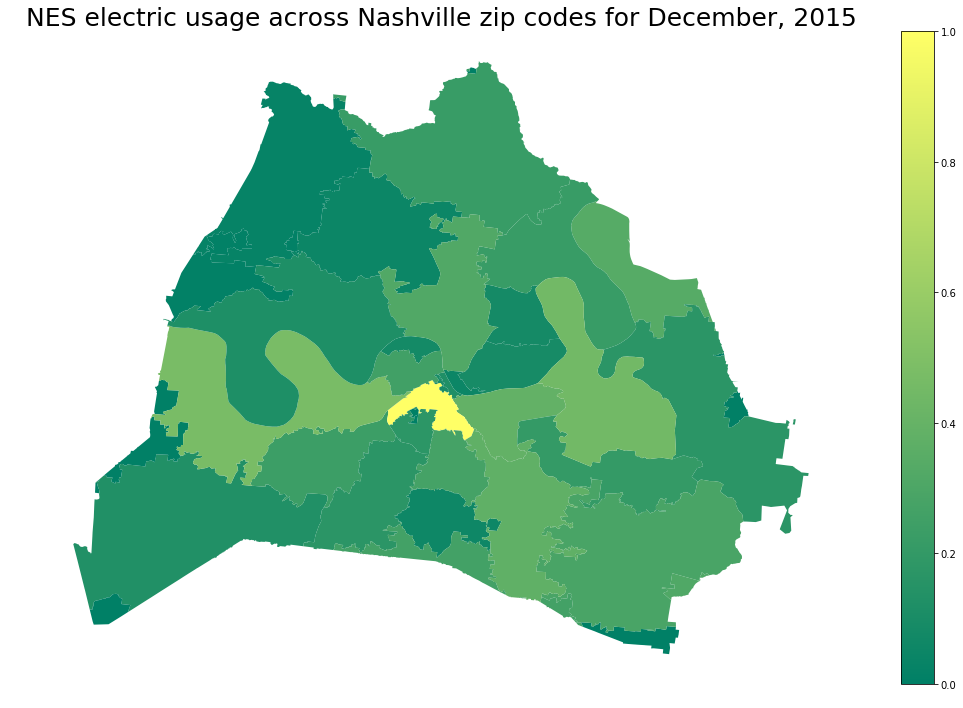

In [50]:
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='summer', norm=plt.Normalize(vmin=0, vmax=1))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

zip_codes_gpd.plot(
    column='monthly_kwh_used',
    ax=ax,
    cmap='summer'
)

ax.set_title(
    f'NES electric usage across Nashville zip codes for {months[MONTH]}, {YEAR}',
    fontdict={
        'fontsize': '25', 
        'fontweight' : '3'
    }
);

0 2012.0 1
1 2012.0 2


/Users/taylorperkins/.virtualenvs/nes-monthly-useage/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


2 2012.0 3
3 2012.0 4
4 2012.0 5
5 2012.0 6
6 2012.0 7
7 2012.0 8
8 2012.0 9
9 2012.0 10
10 2012.0 11
11 2012.0 12
12 2013.0 1
13 2013.0 2
14 2013.0 3
15 2013.0 4
16 2013.0 5
17 2013.0 6
18 2013.0 7
19 2013.0 8
20 2013.0 9
21 2013.0 10
22 2013.0 11
23 2013.0 12
24 2014.0 1
25 2014.0 2
26 2014.0 3
27 2014.0 4
28 2014.0 5
29 2014.0 6
30 2014.0 7
31 2014.0 8
32 2014.0 9
33 2014.0 10
34 2014.0 11
35 2014.0 12
36 2015.0 1
37 2015.0 2
38 2015.0 3
39 2015.0 4
40 2015.0 5
41 2015.0 6
42 2015.0 7
43 2015.0 8
44 2015.0 9
45 2015.0 10
46 2015.0 11
47 2015.0 12
48 2016.0 1
49 2016.0 2
50 2016.0 3
51 2016.0 4
52 2016.0 5
53 2016.0 6
54 2016.0 7
55 2016.0 8
56 2016.0 9
57 2016.0 10
58 2016.0 11
59 2016.0 12
60 2017.0 1
61 2017.0 2
62 2017.0 3
63 2017.0 4
64 2017.0 5
65 2017.0 6
66 2017.0 7
67 2017.0 8
68 2017.0 9
69 2017.0 10
70 2017.0 11
71 2017.0 12
72 2018.0 1
73 2018.0 2
74 2018.0 4
75 2018.0 5
76 2018.0 6
77 2018.0 7
78 2018.0 8


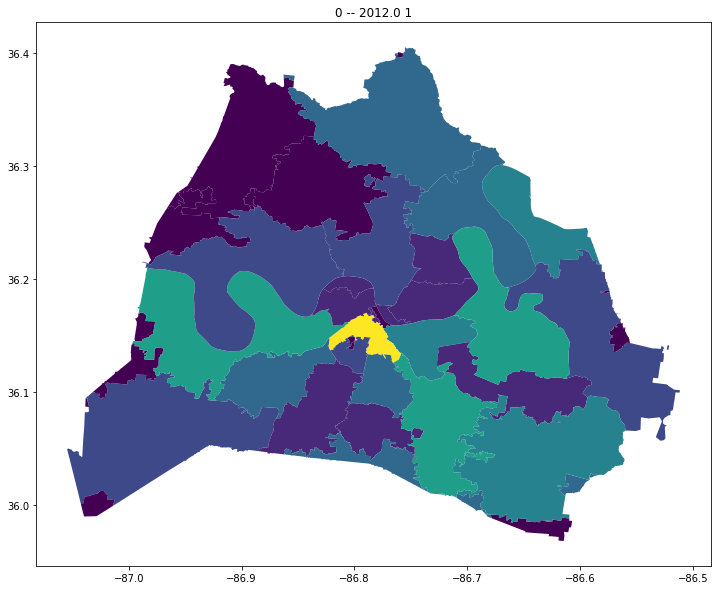

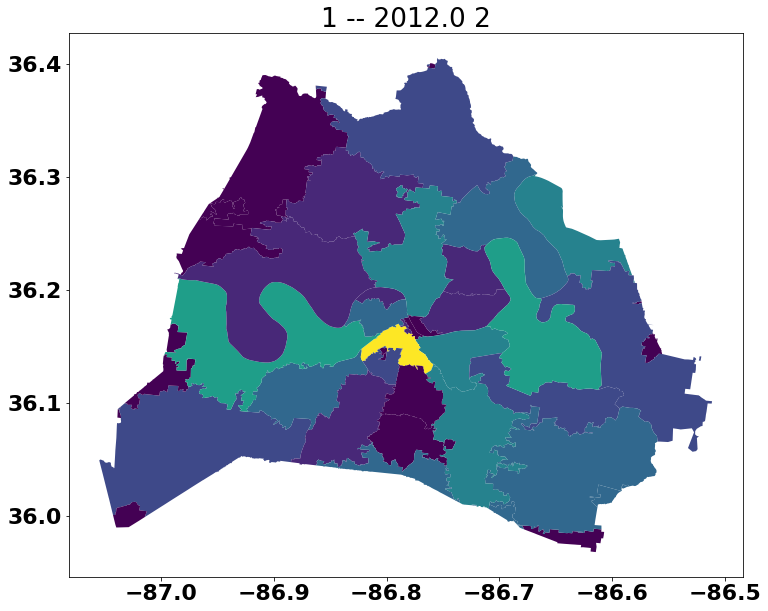

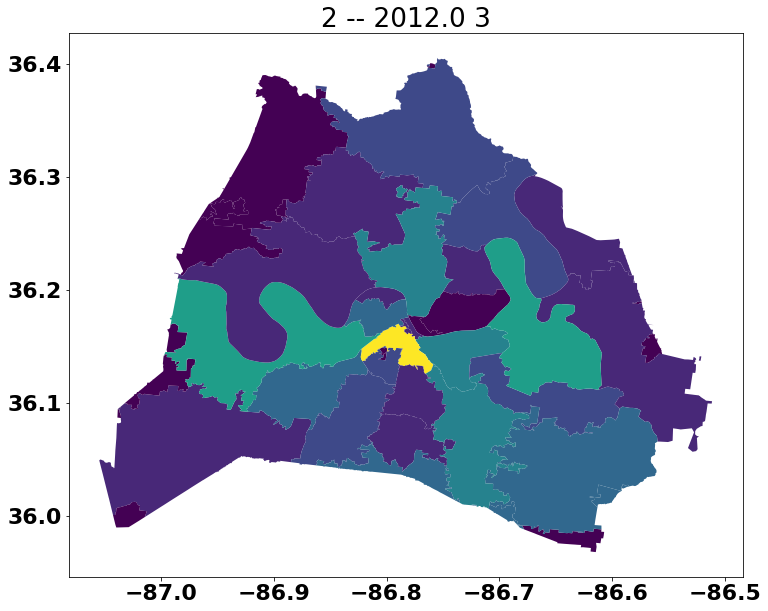

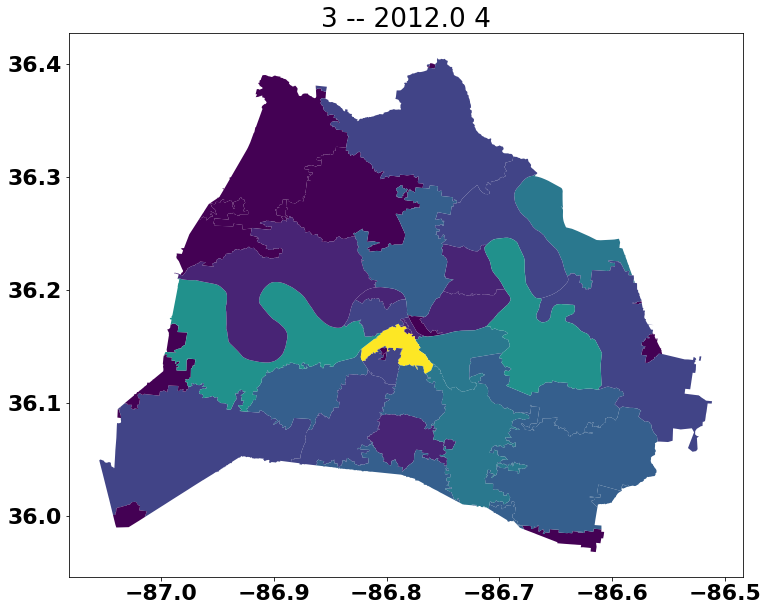

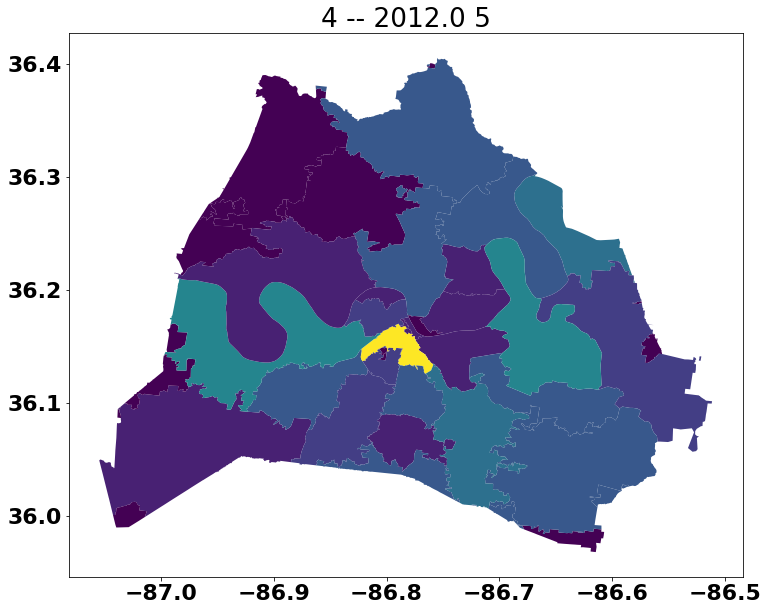

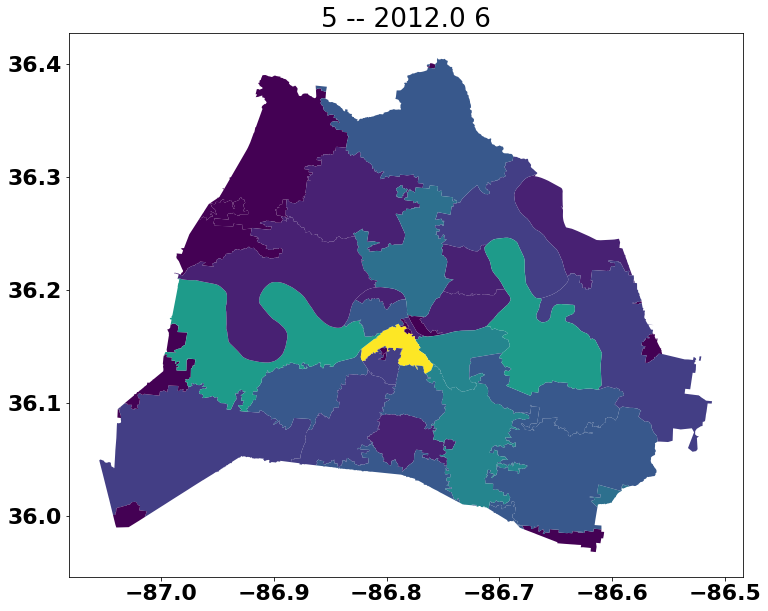

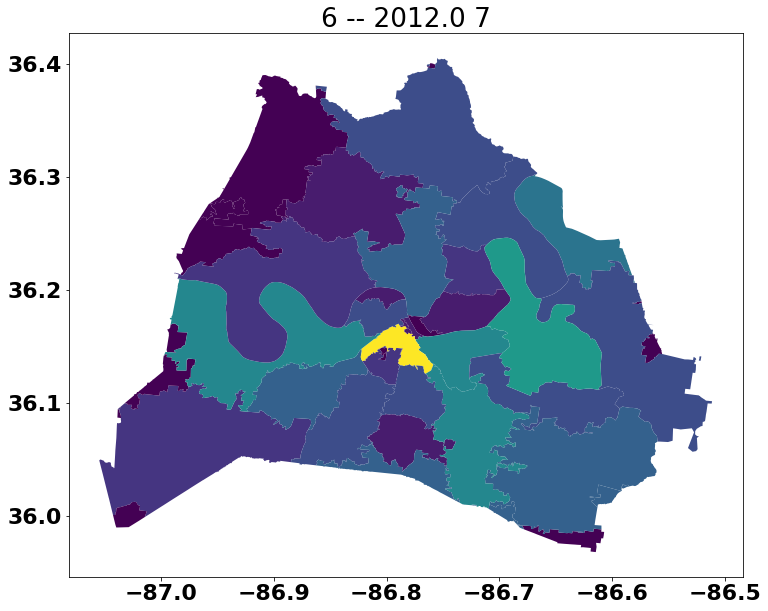

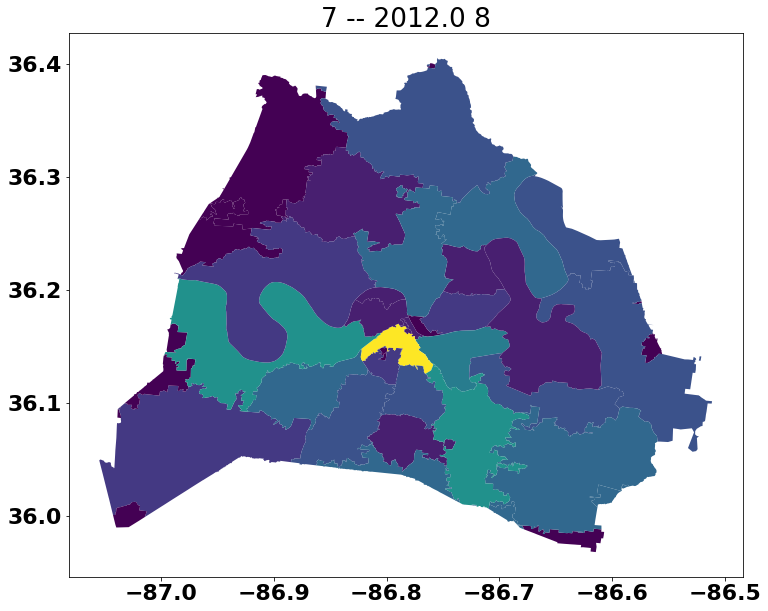

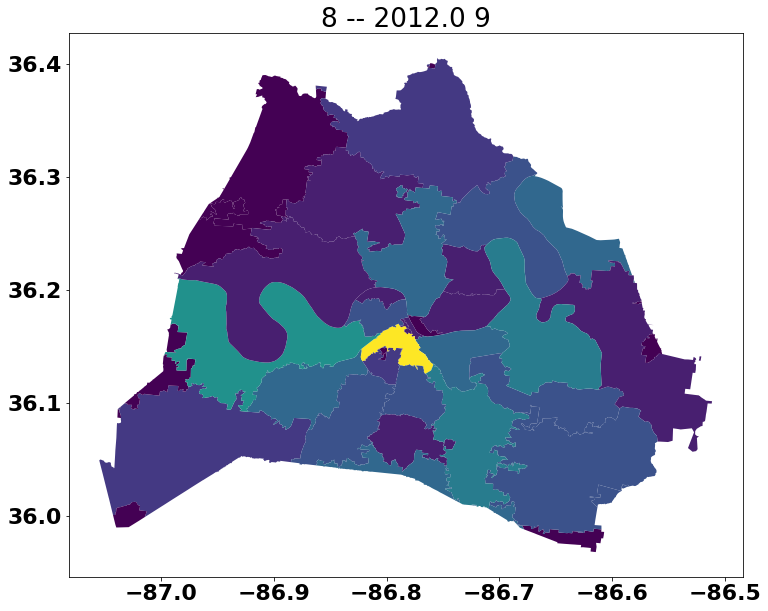

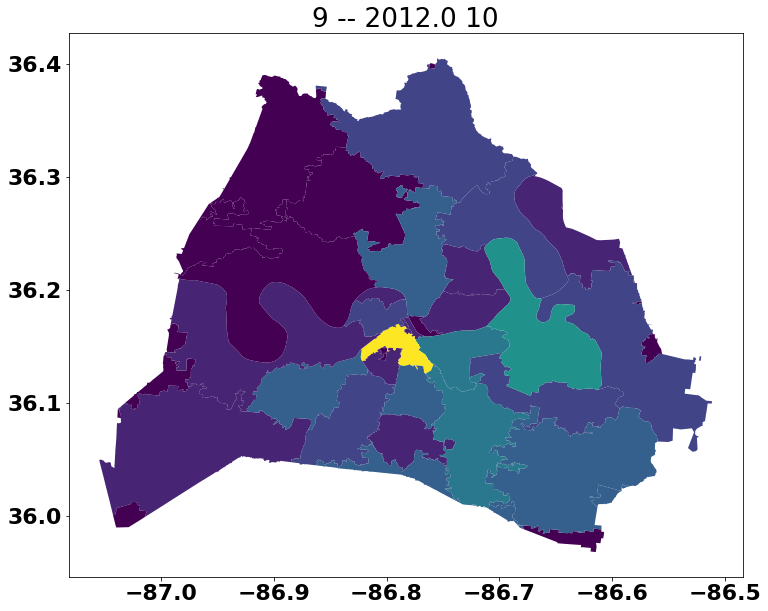

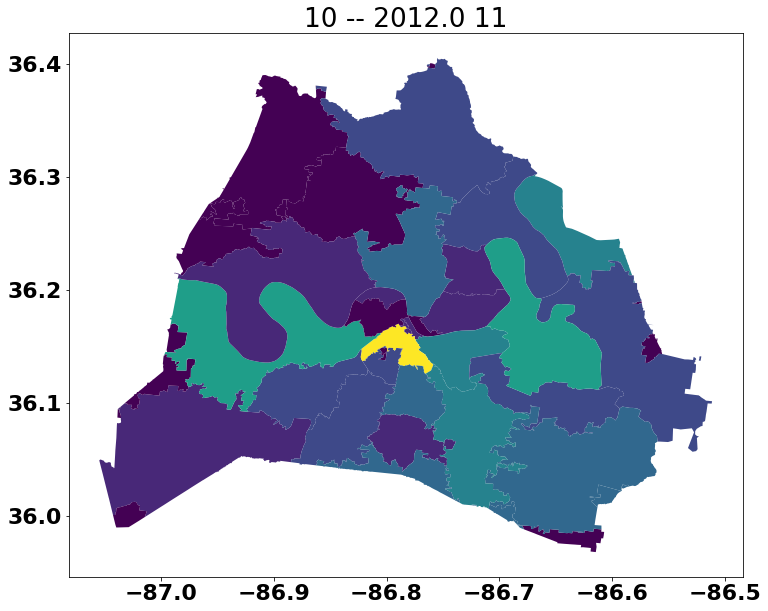

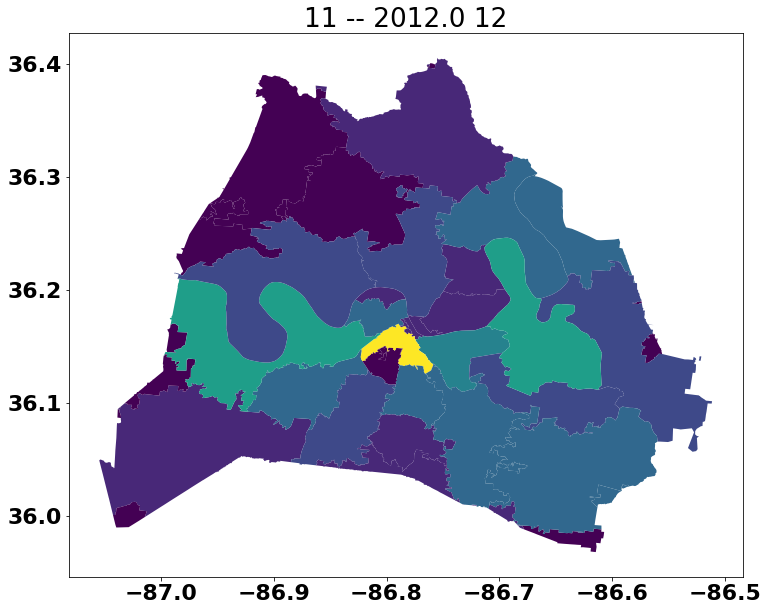

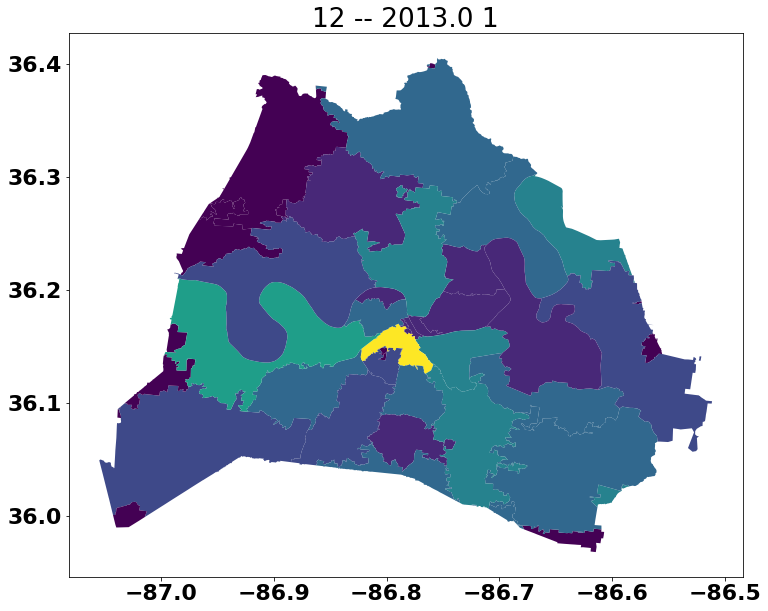

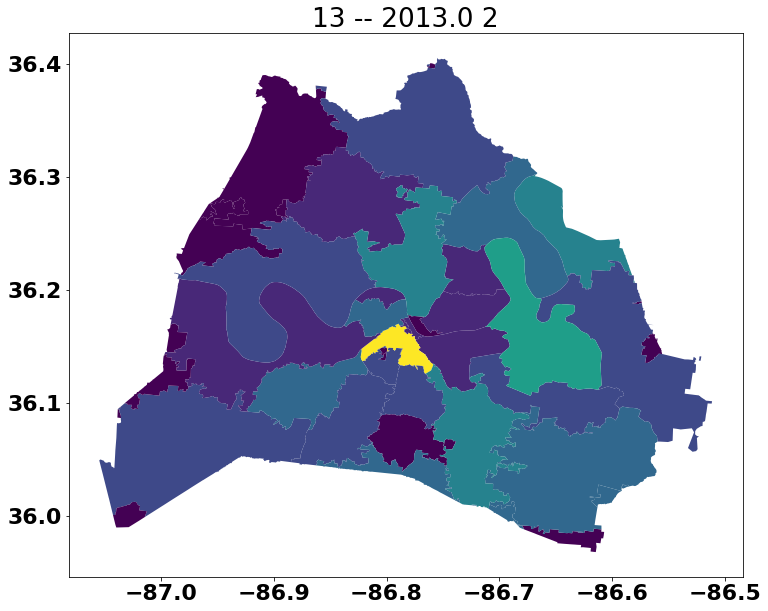

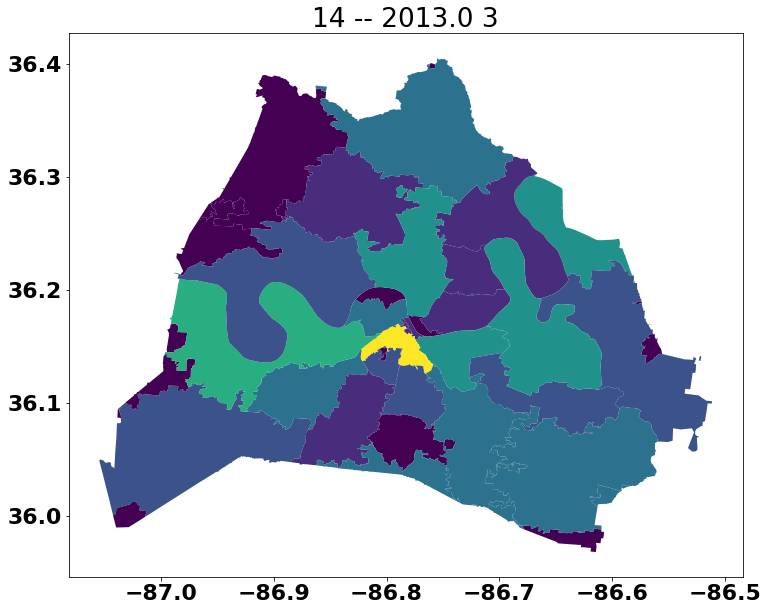

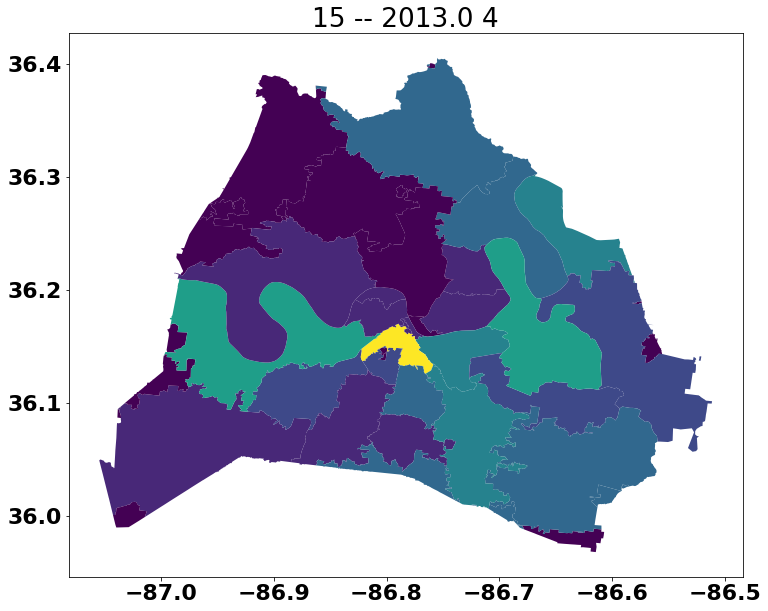

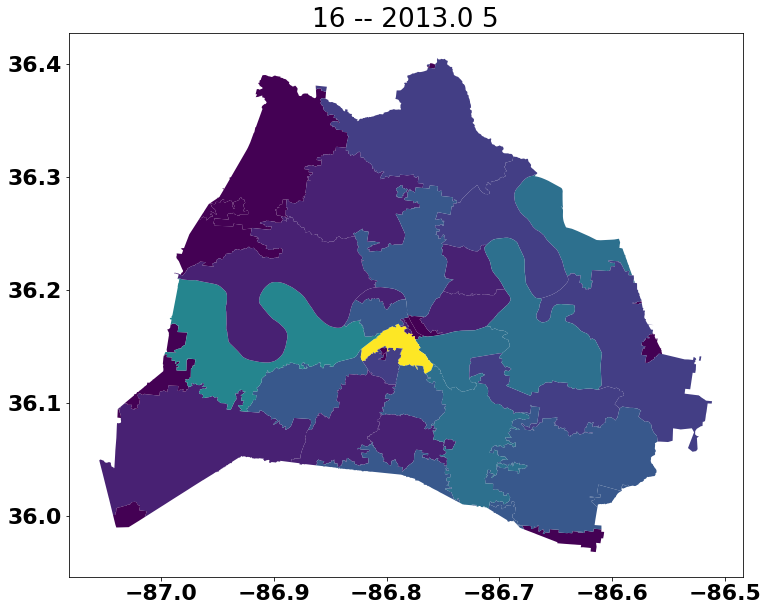

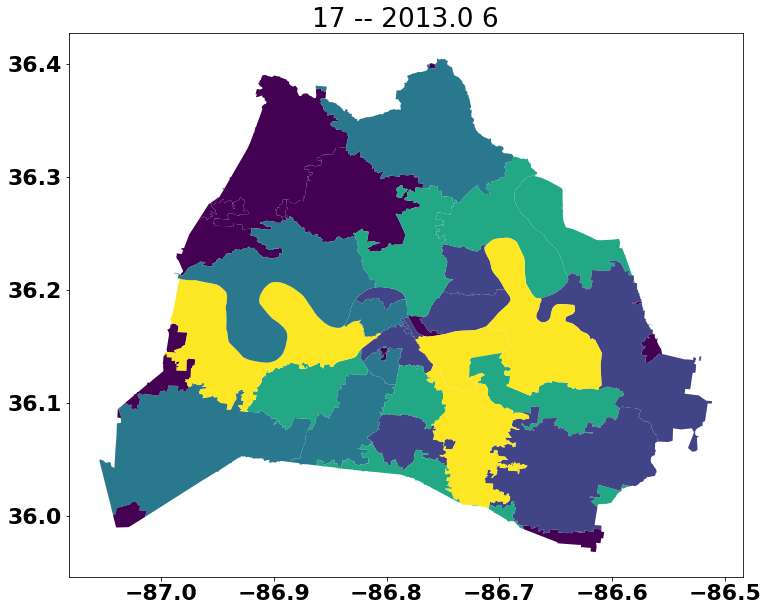

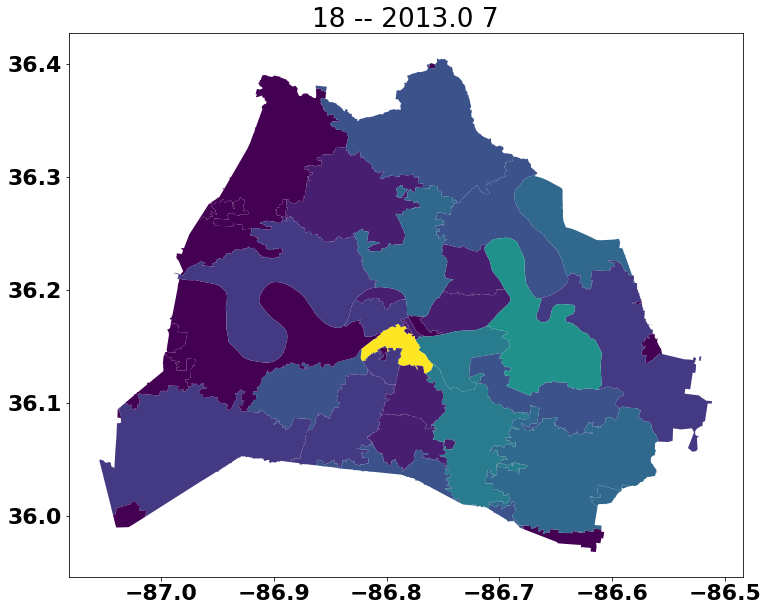

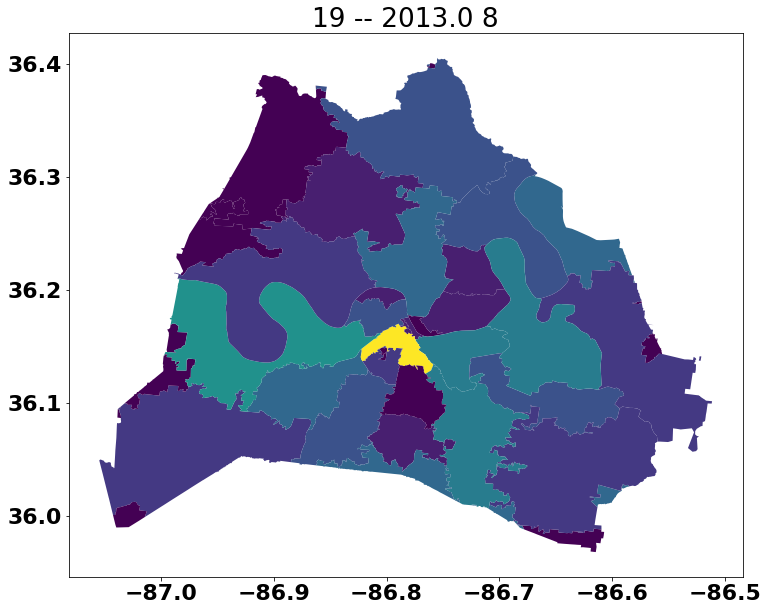

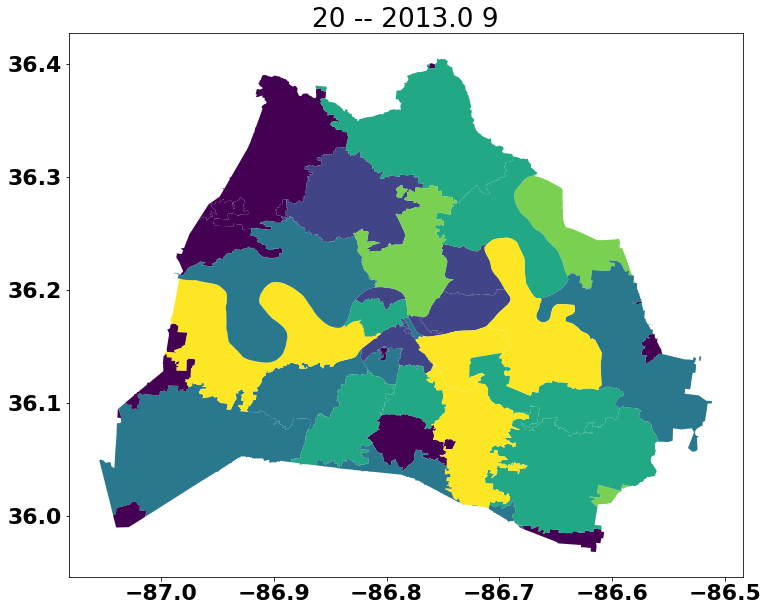

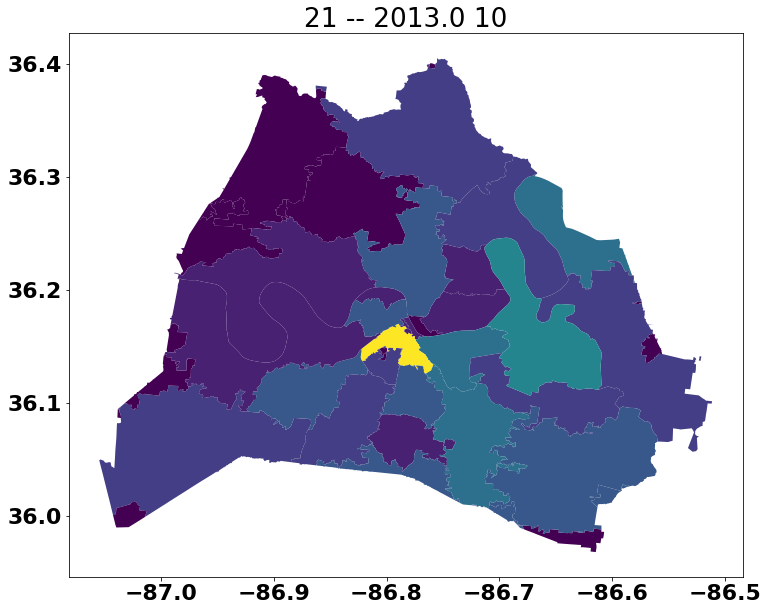

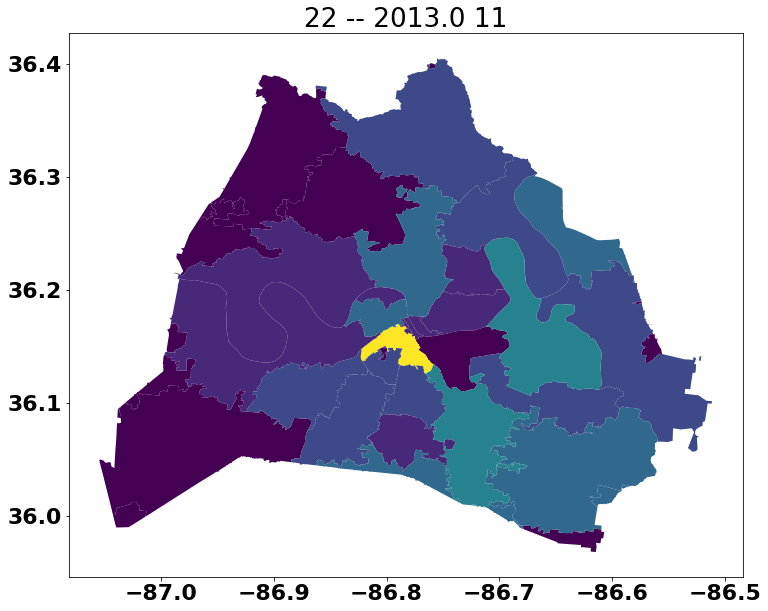

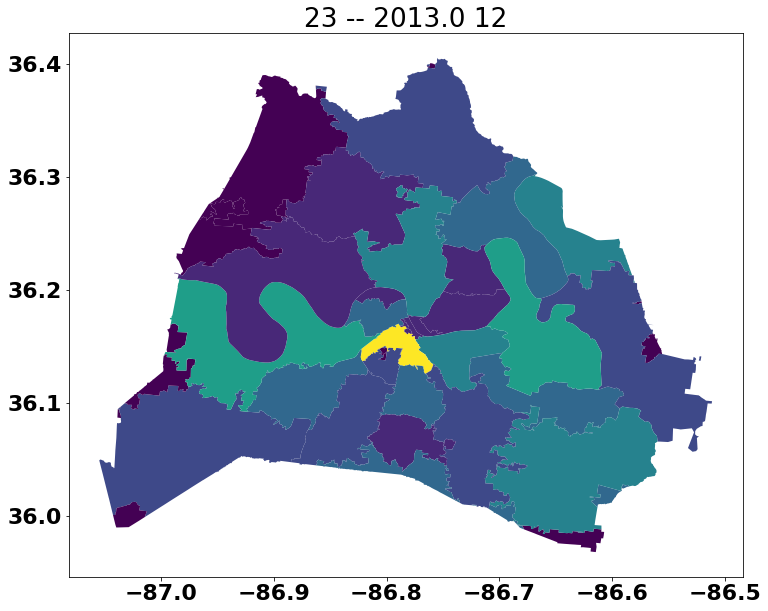

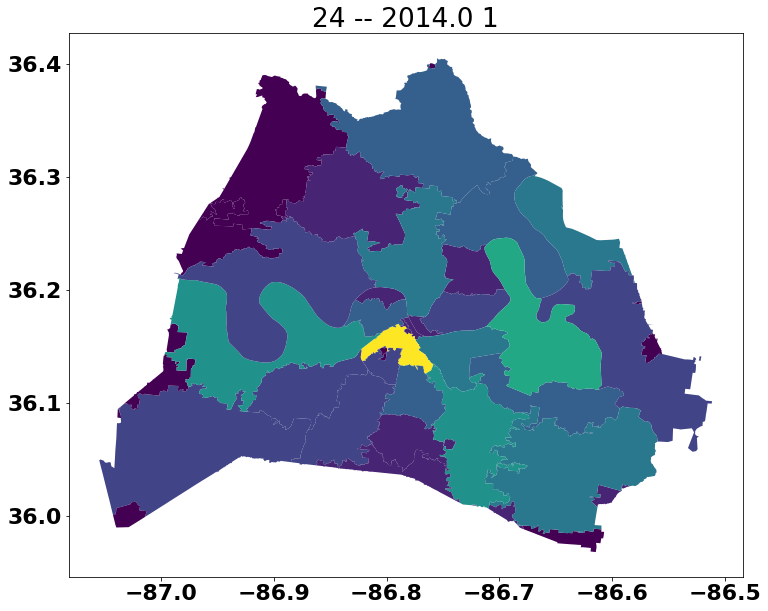

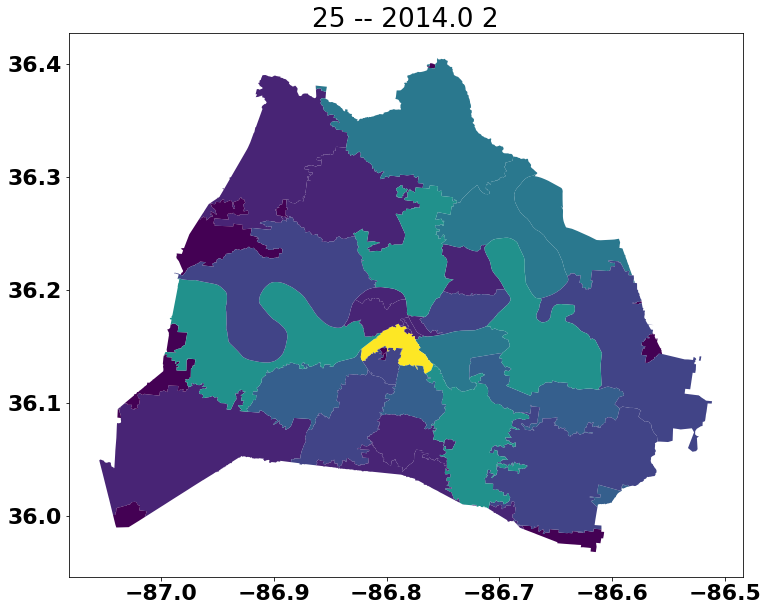

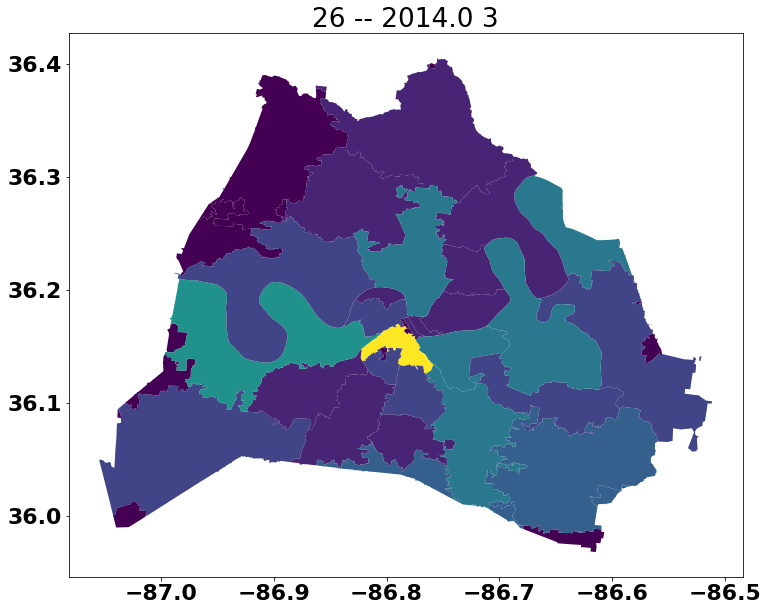

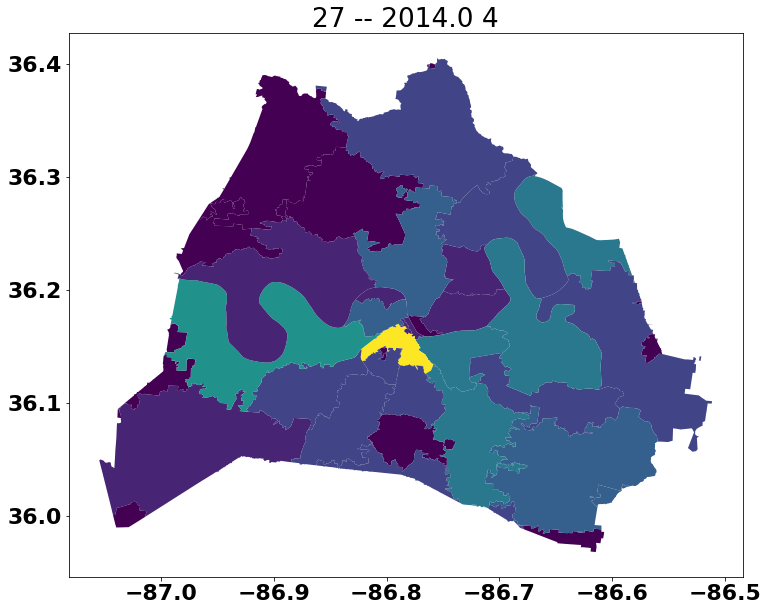

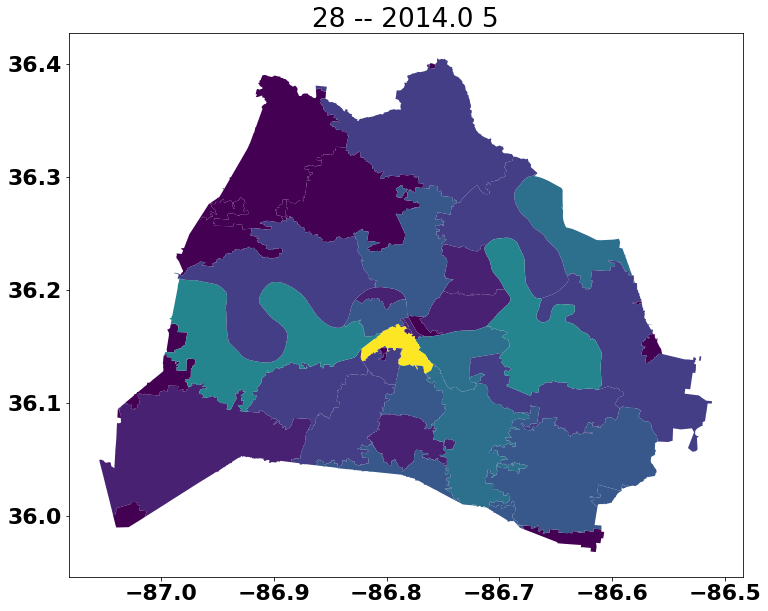

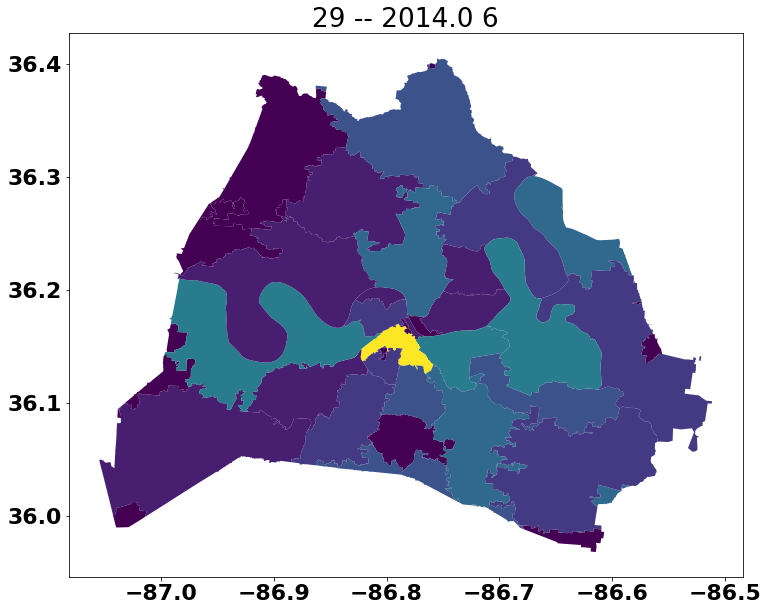

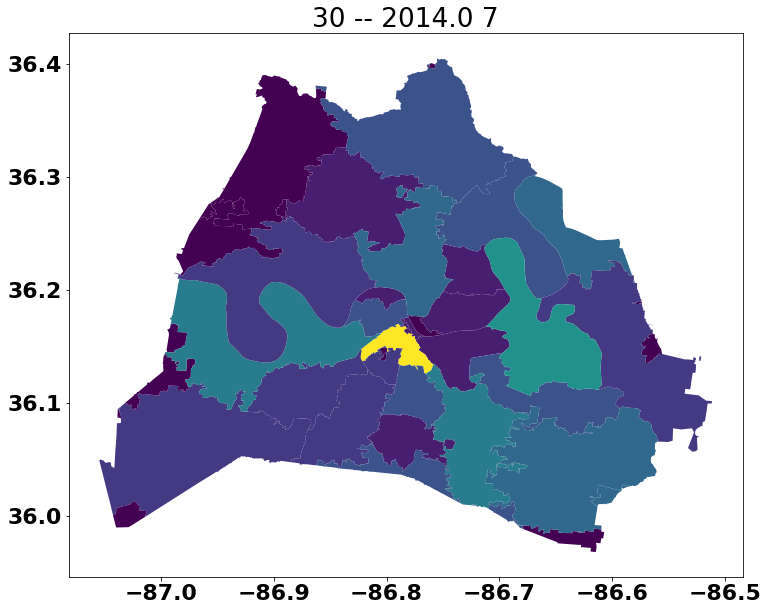

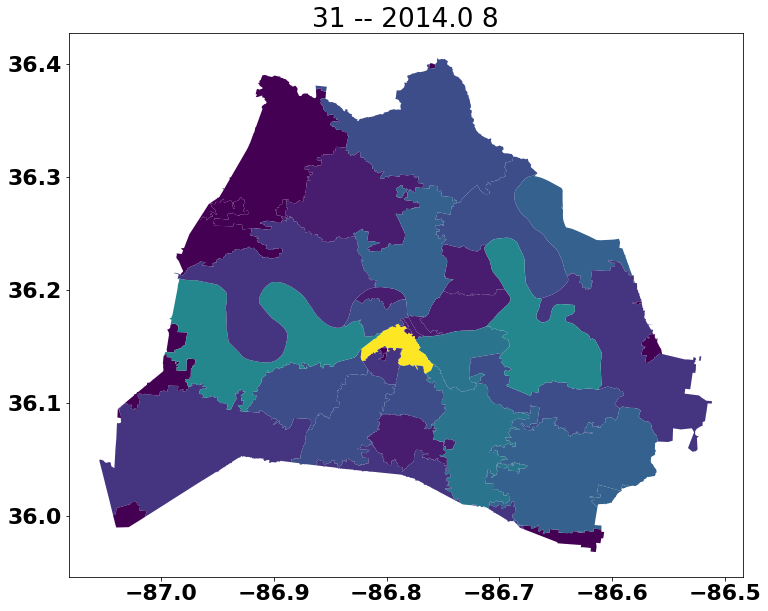

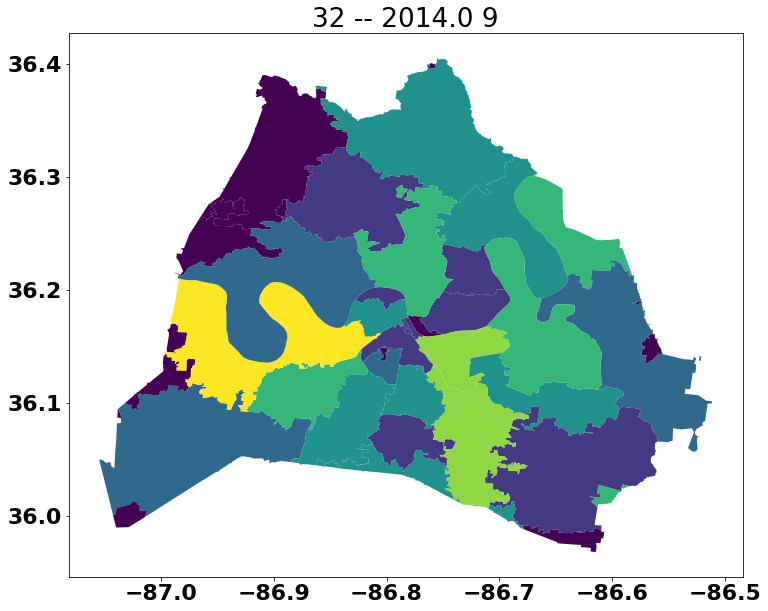

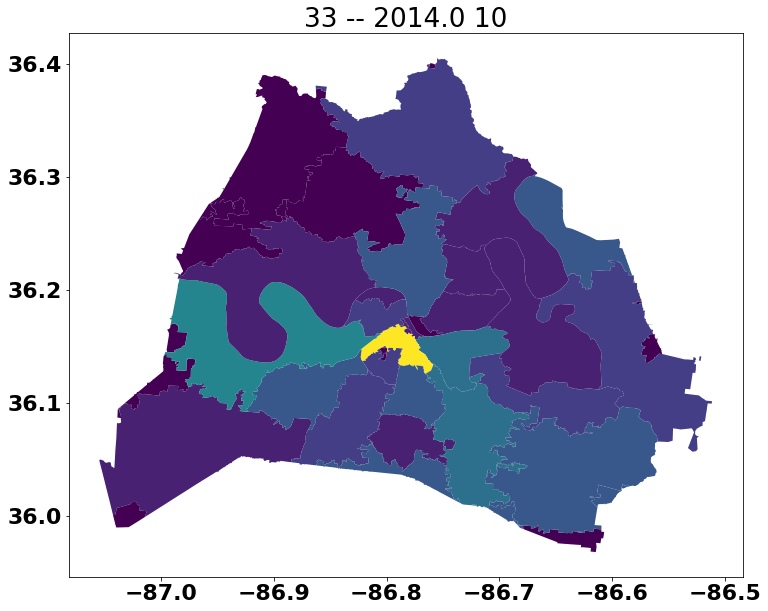

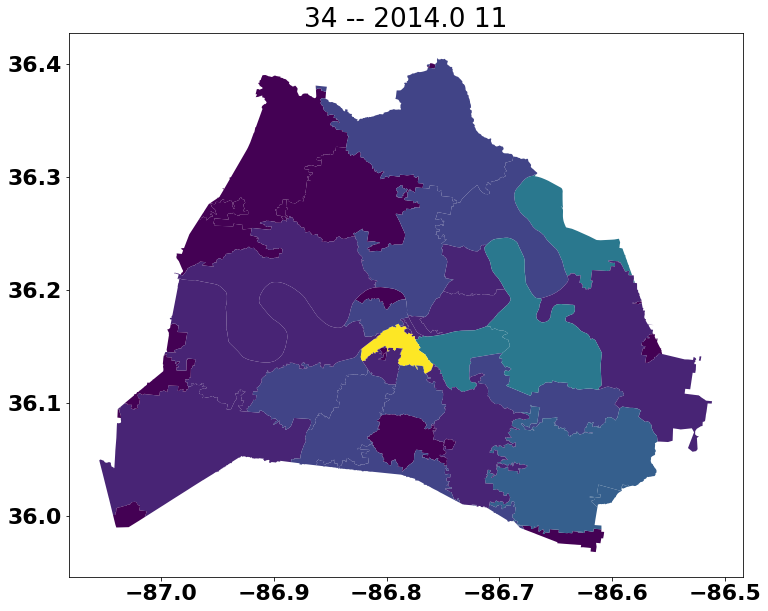

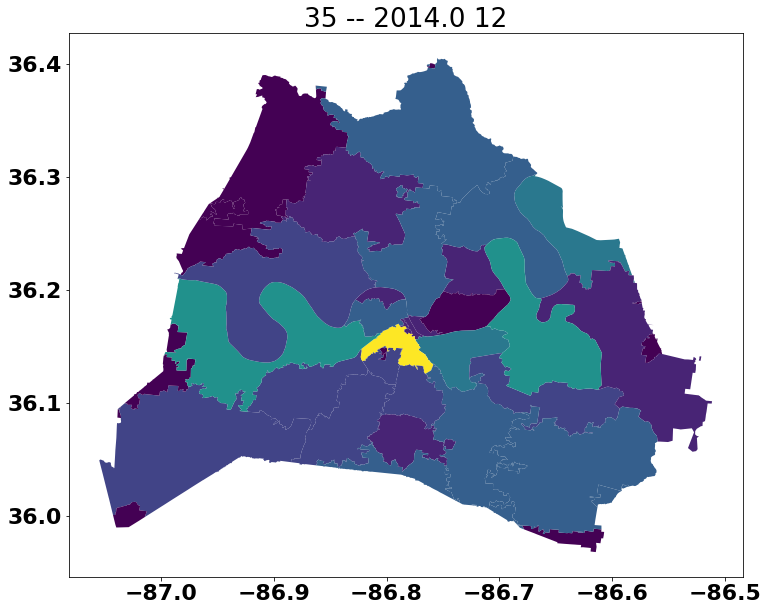

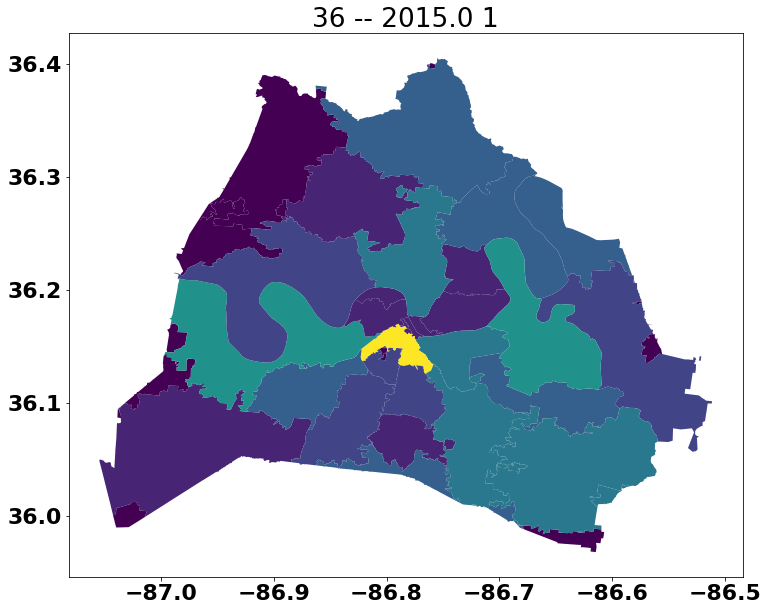

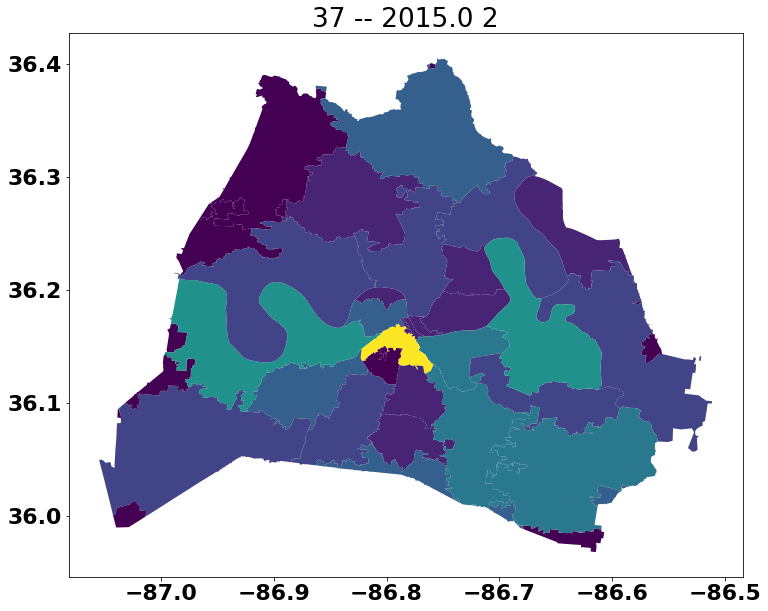

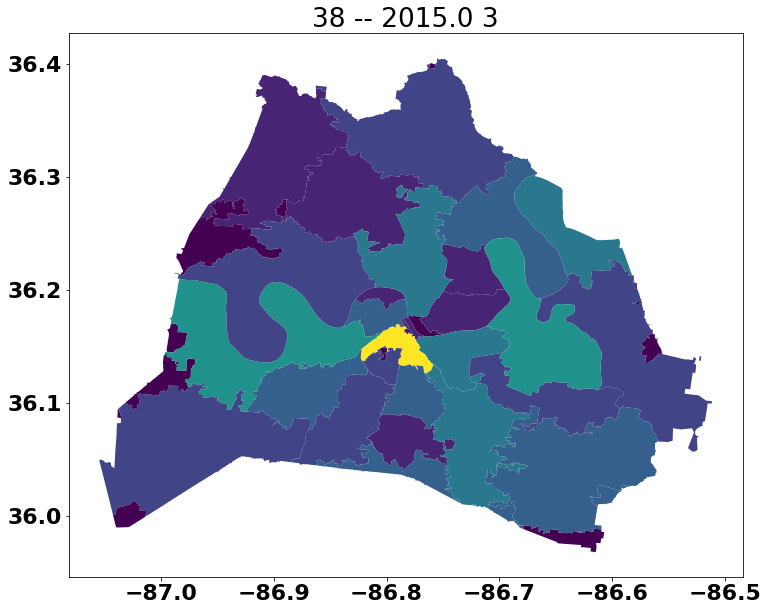

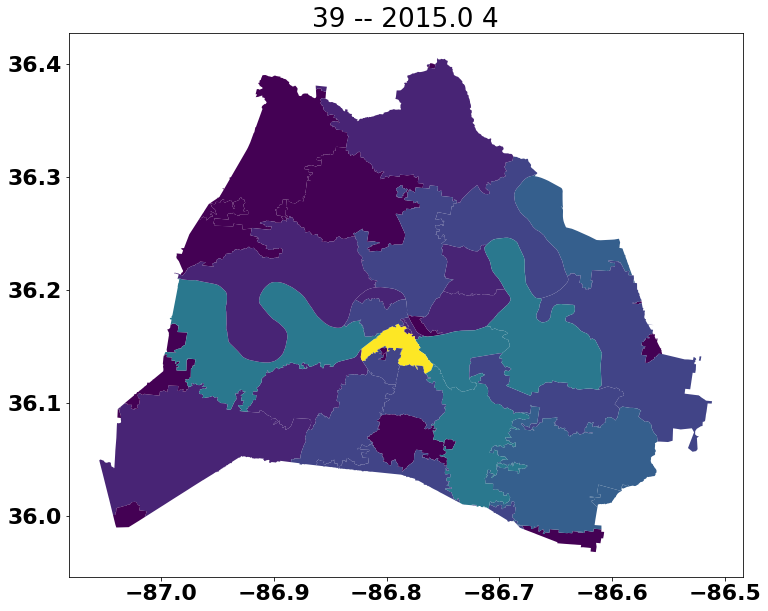

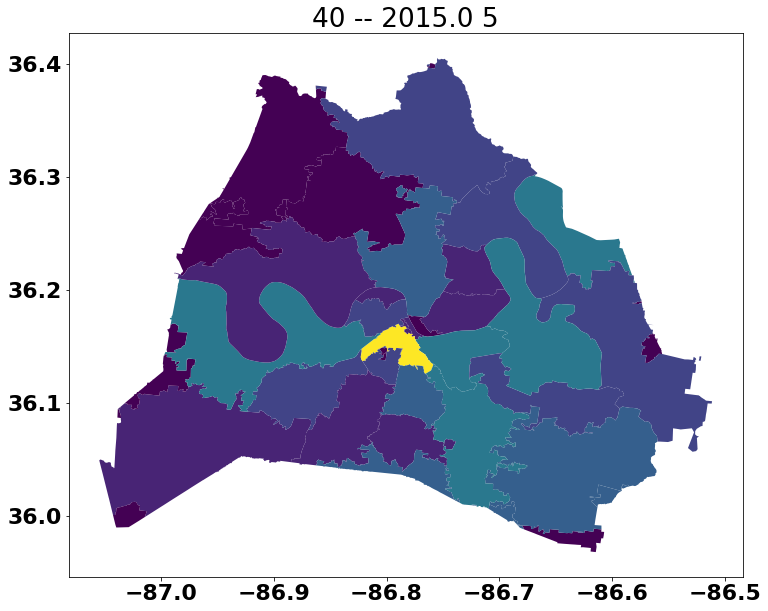

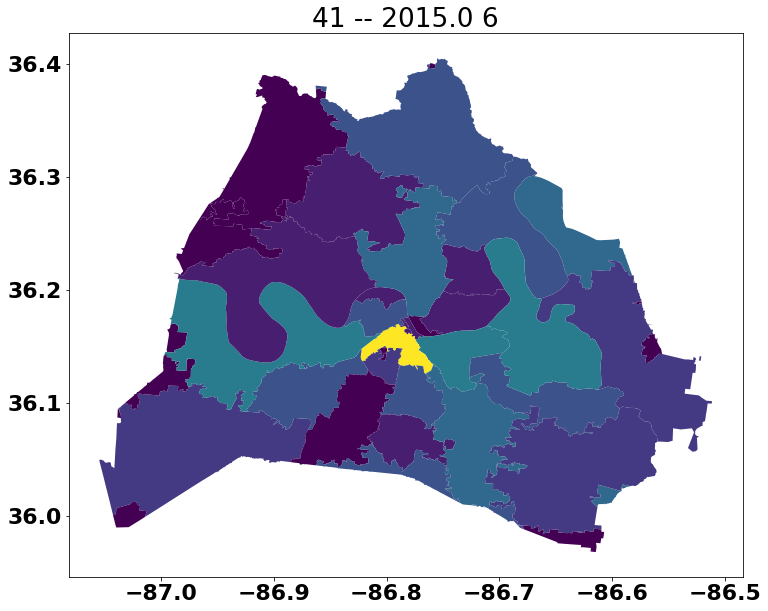

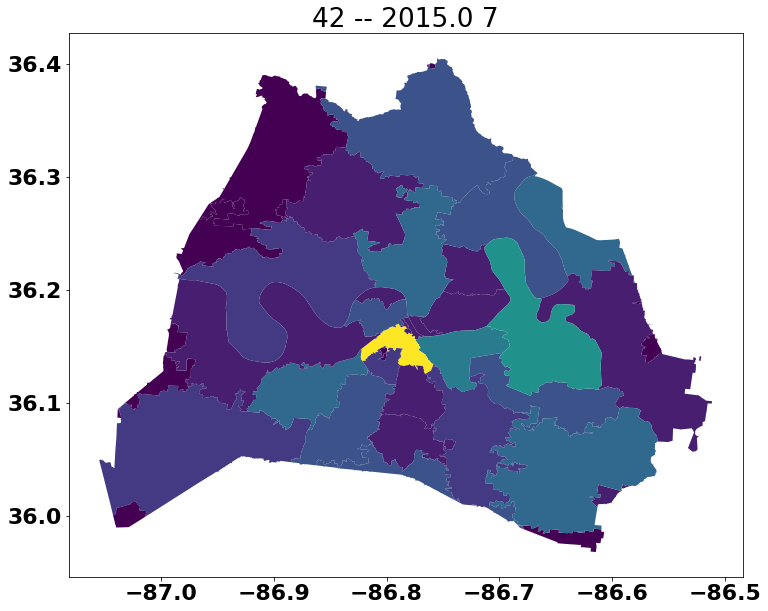

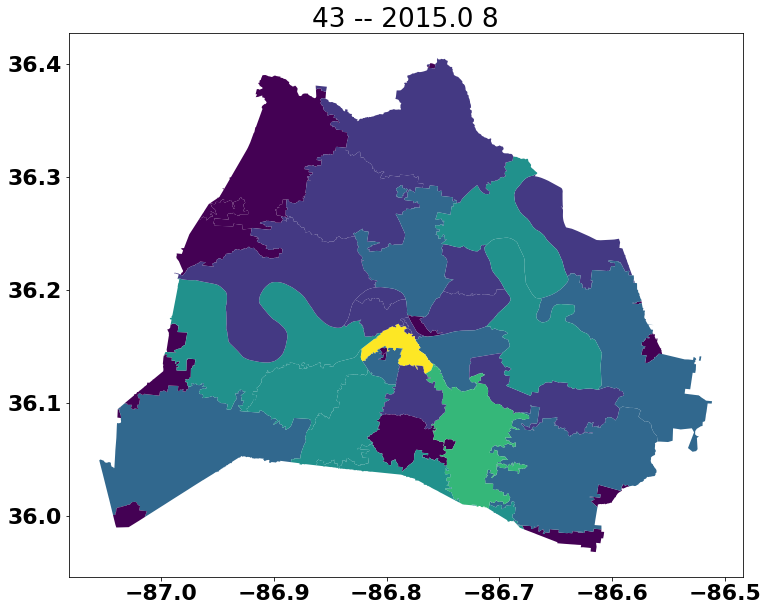

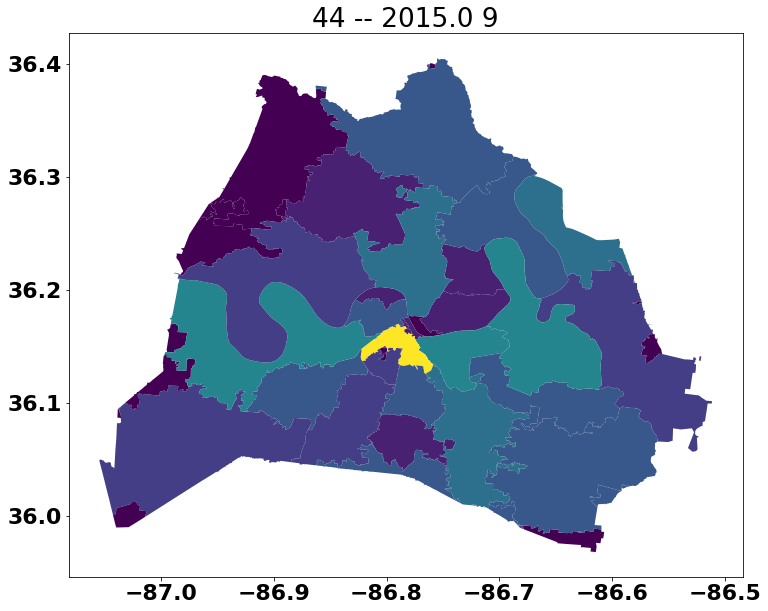

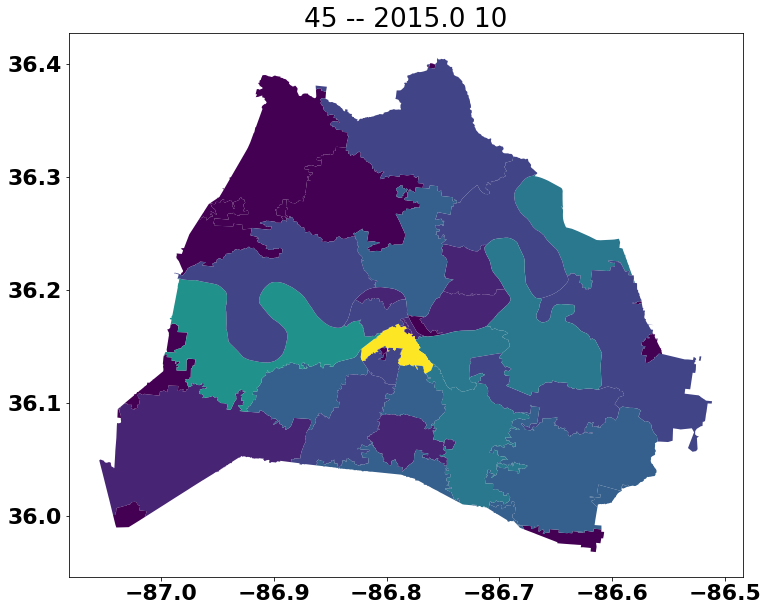

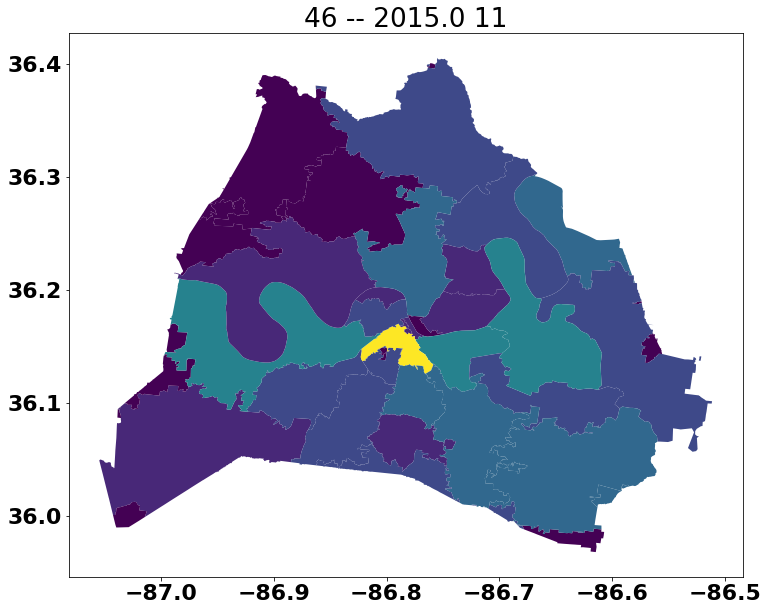

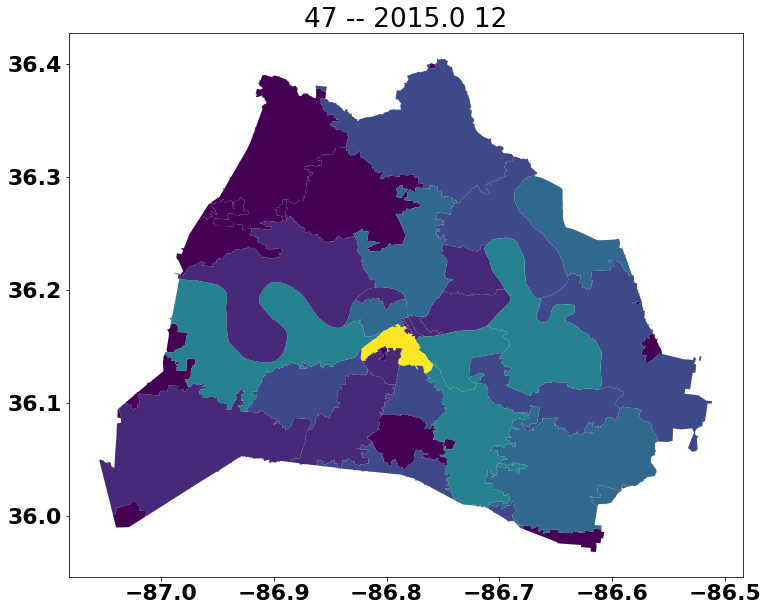

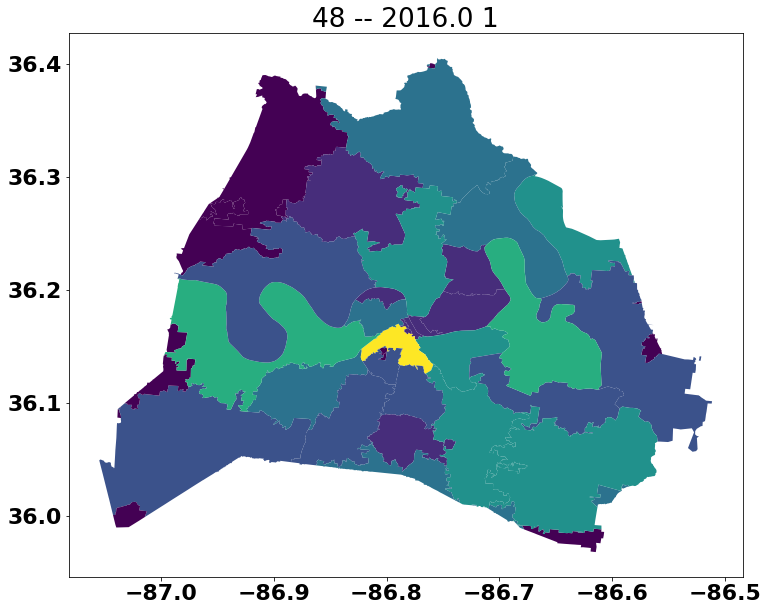

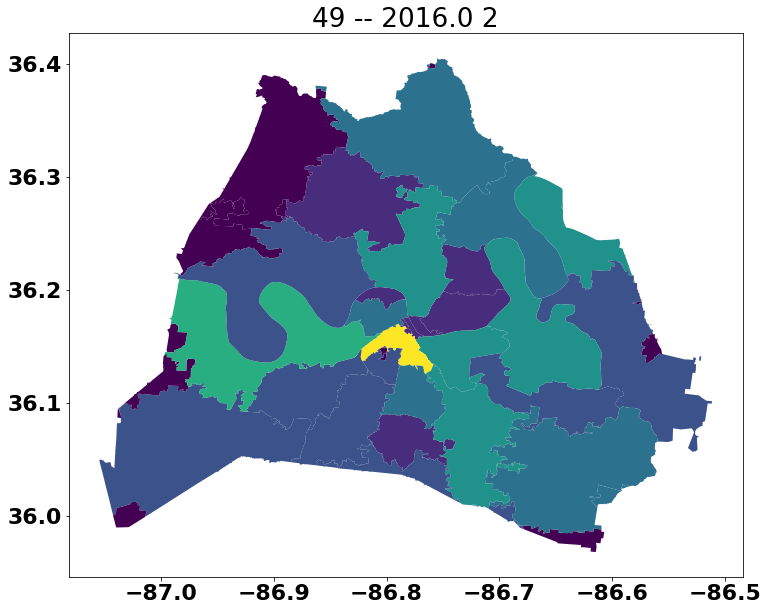

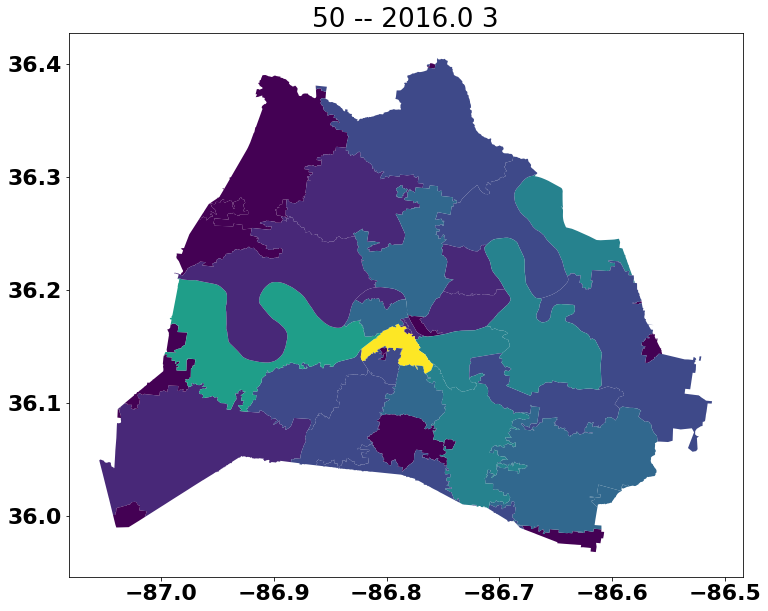

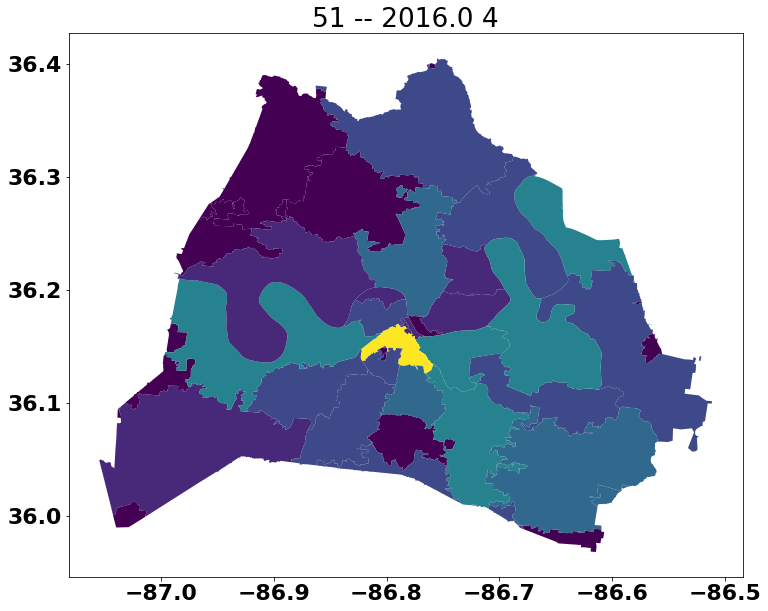

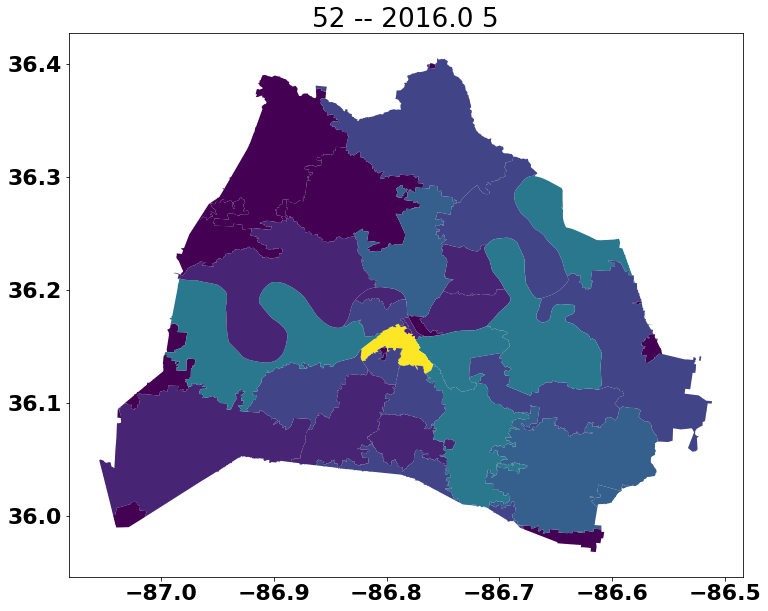

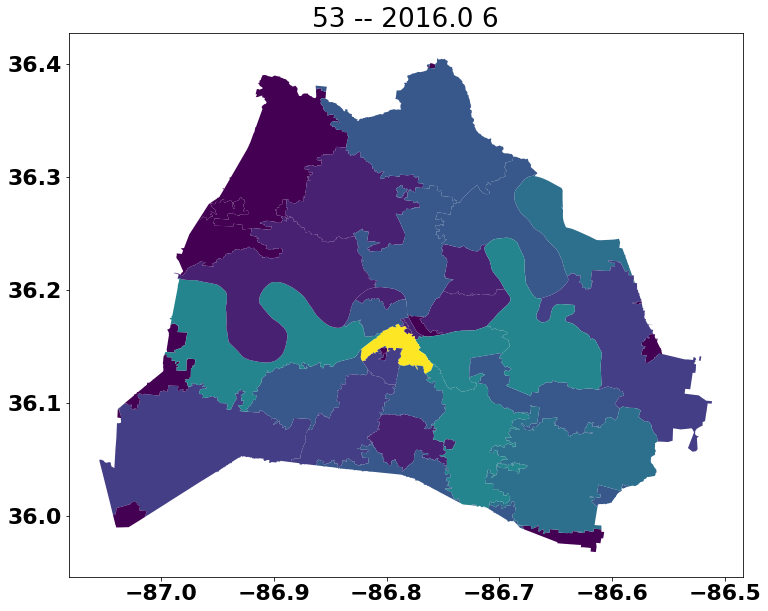

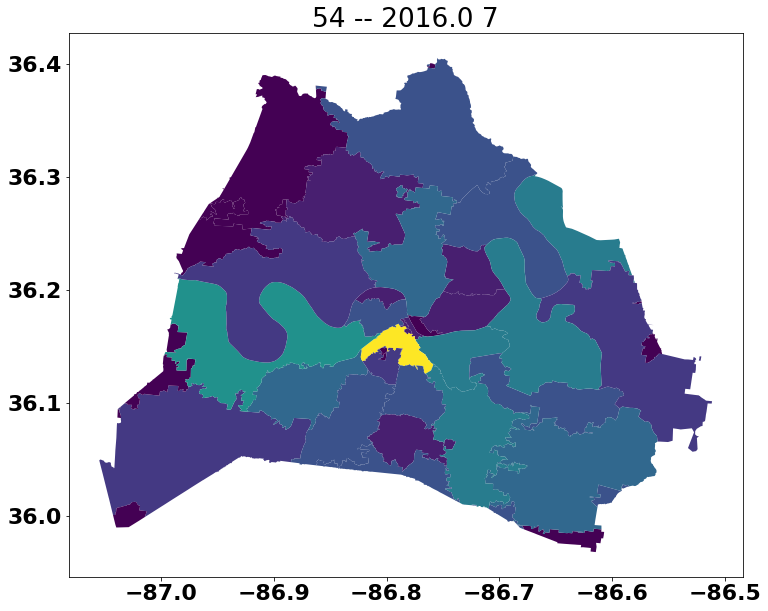

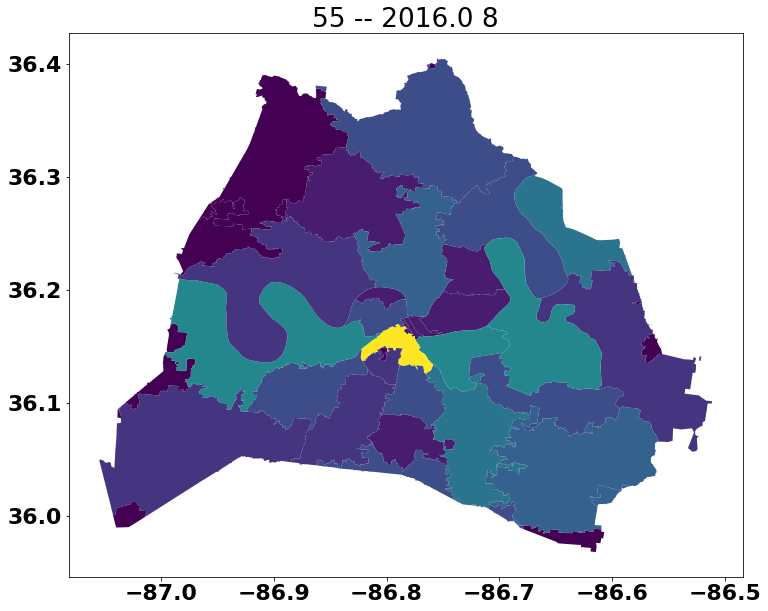

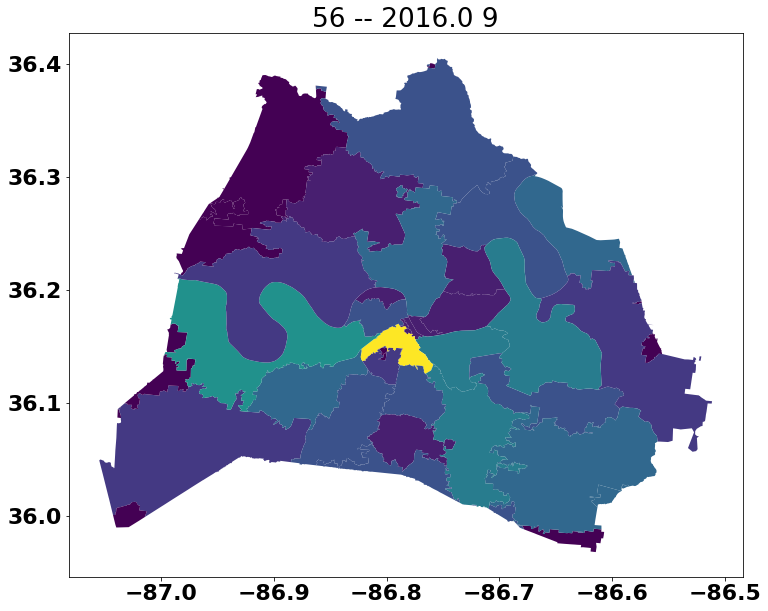

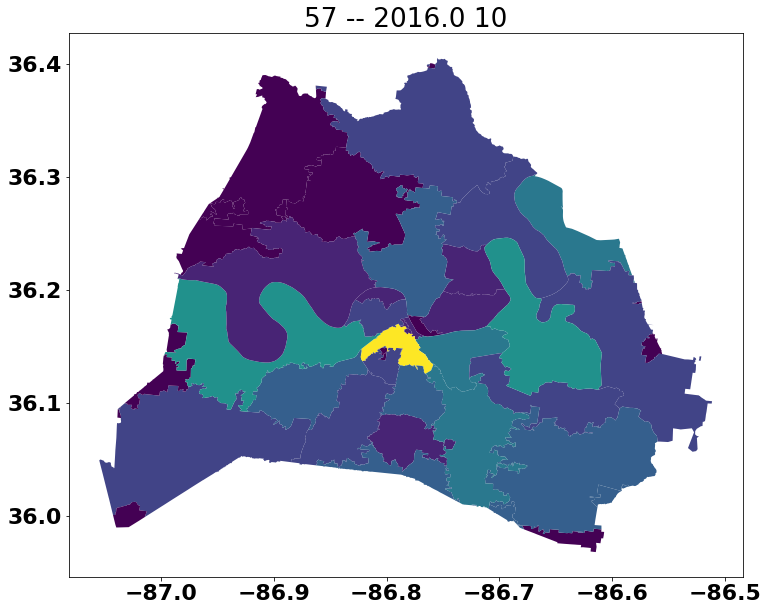

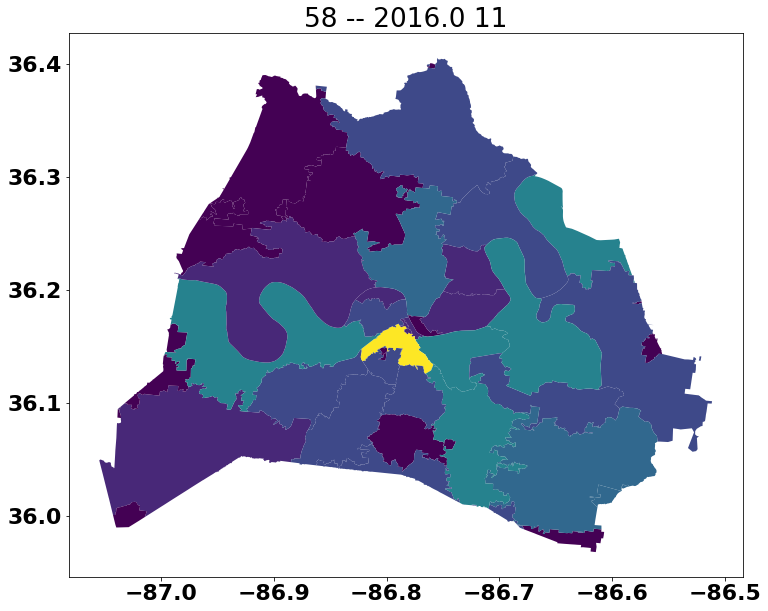

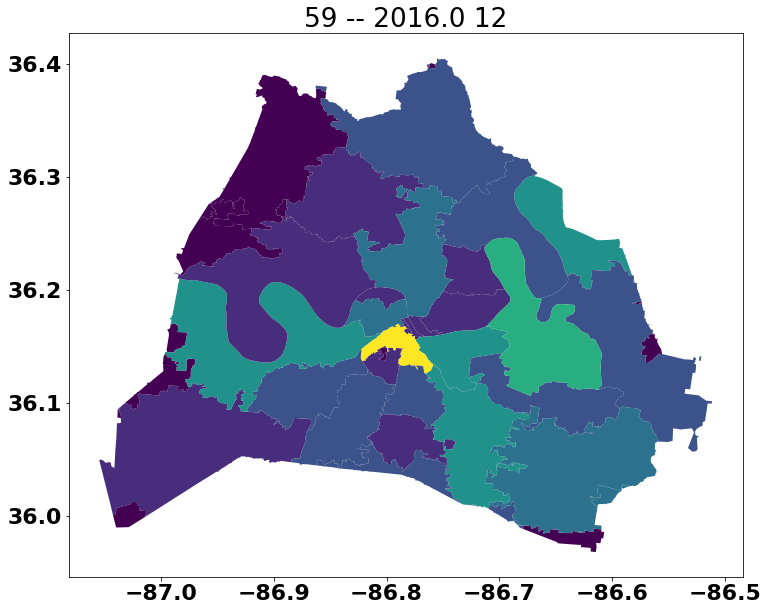

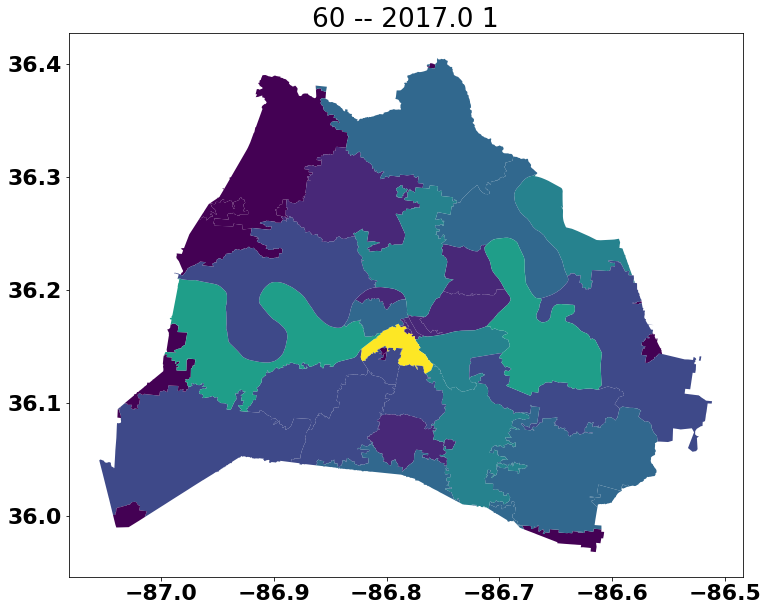

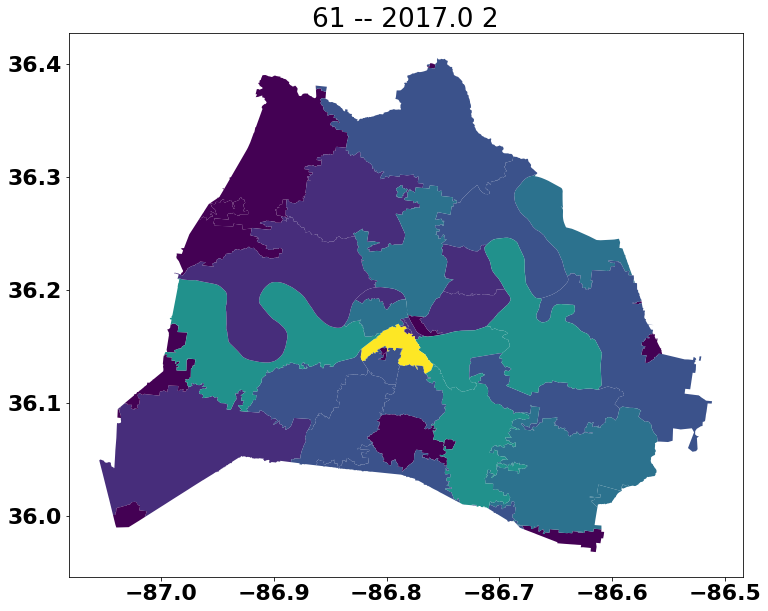

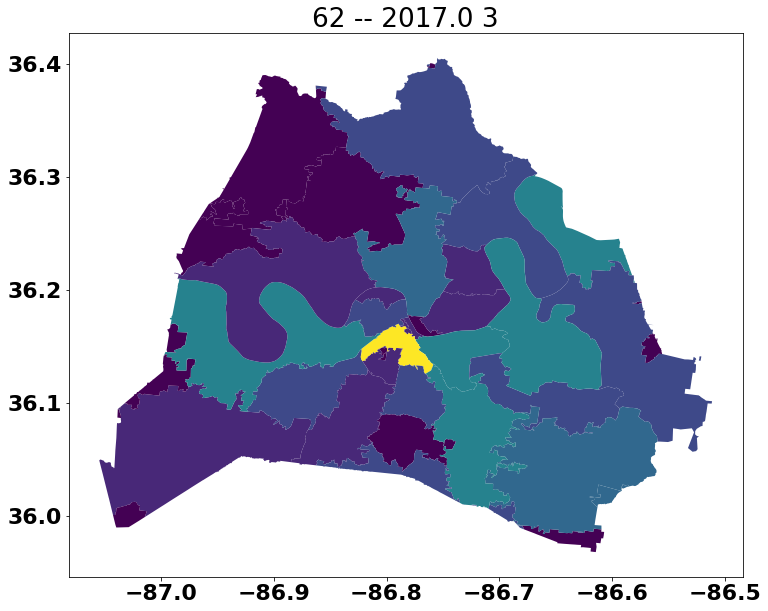

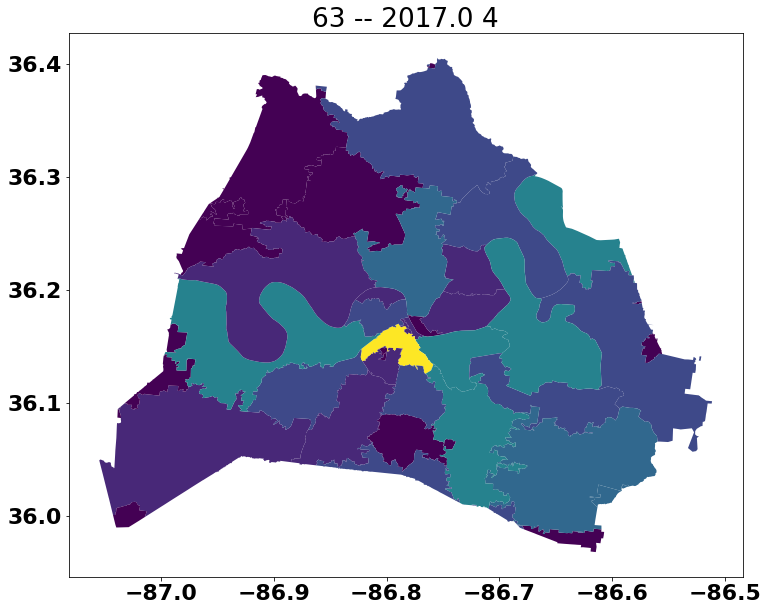

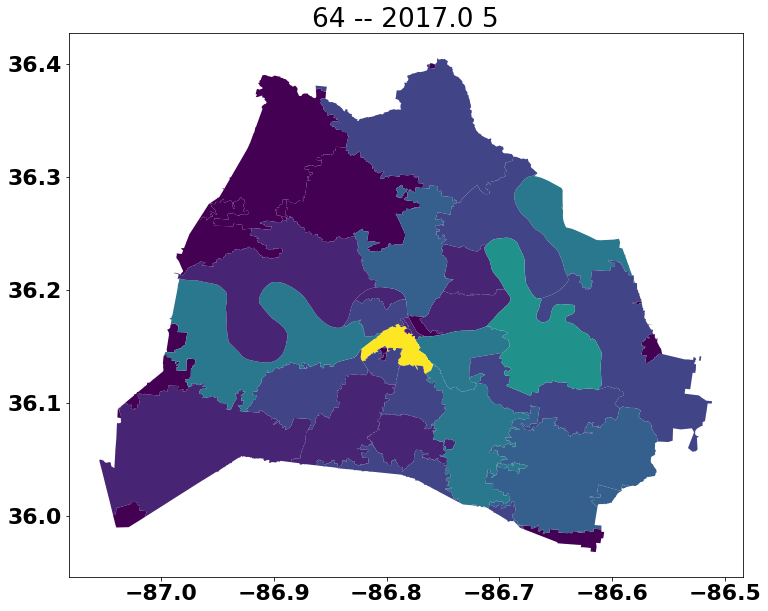

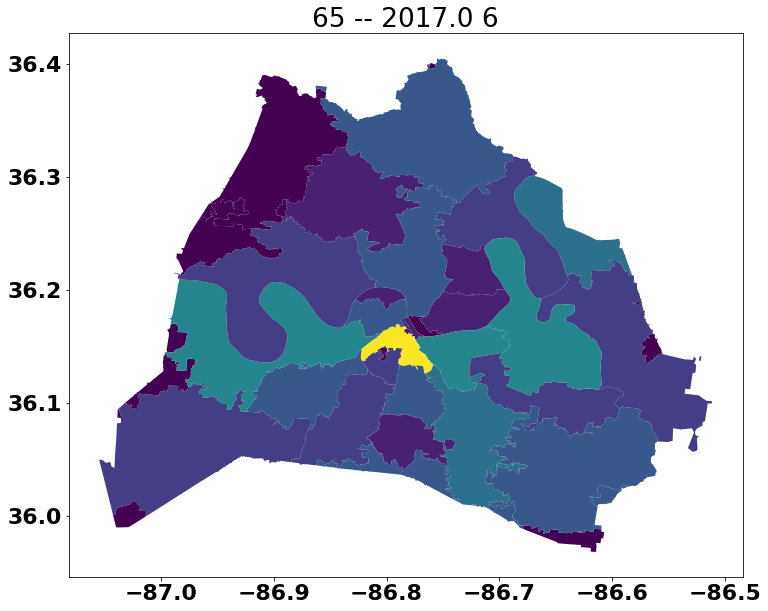

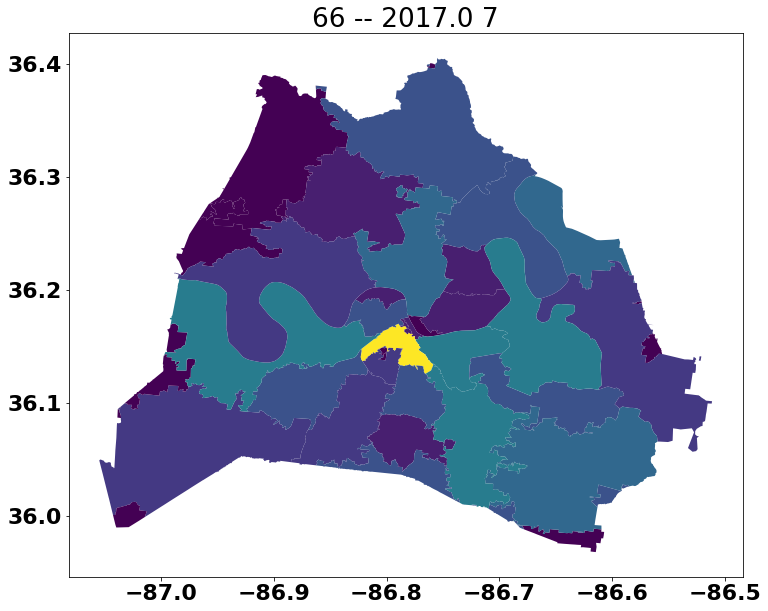

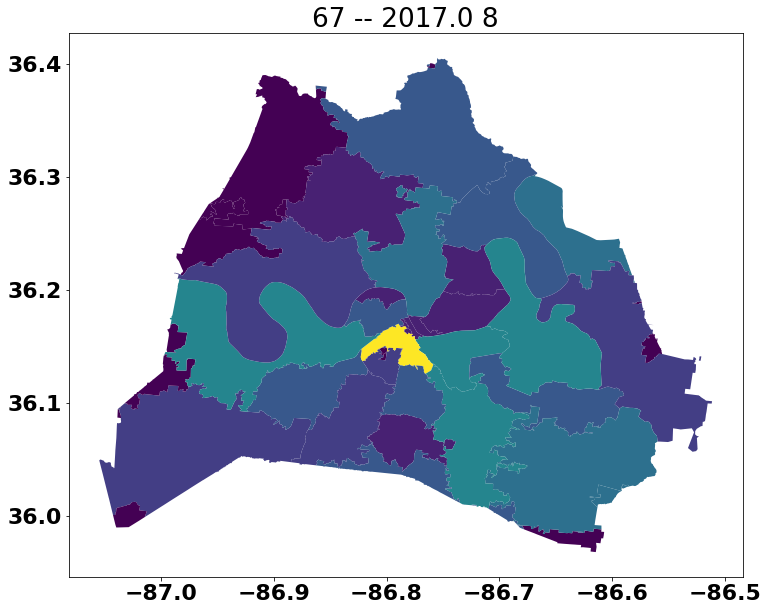

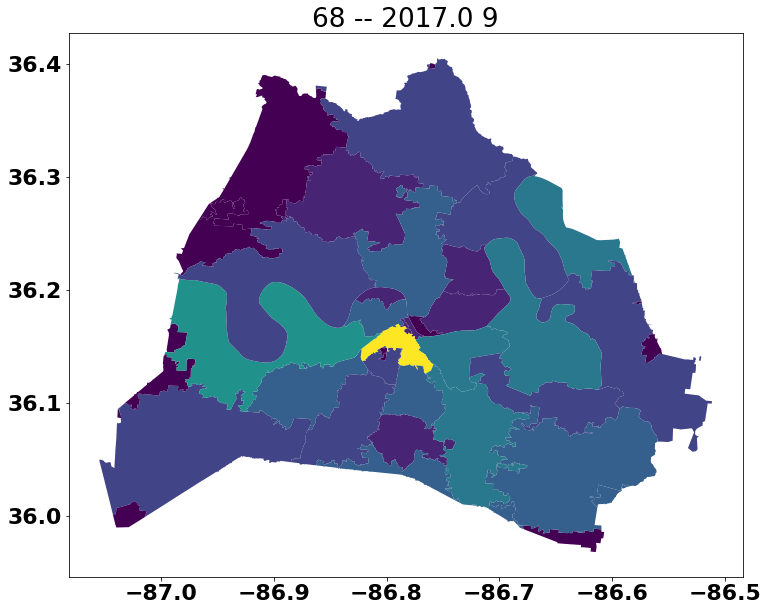

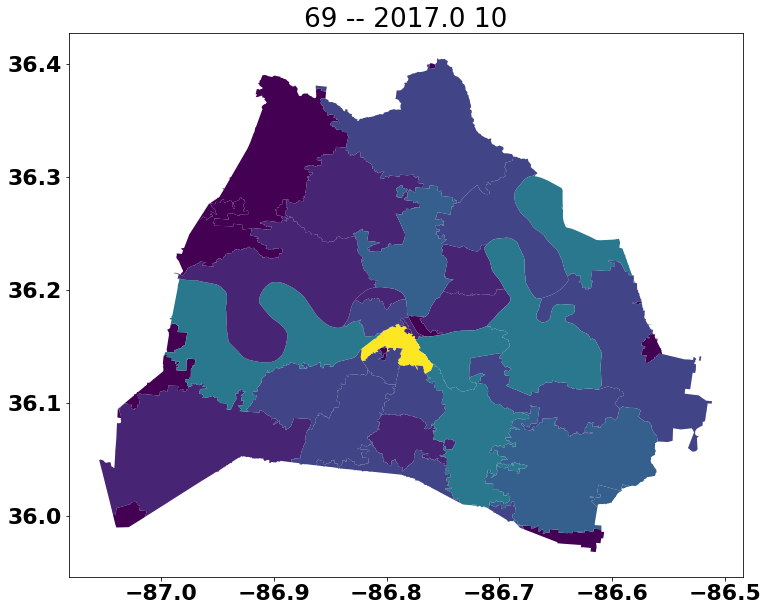

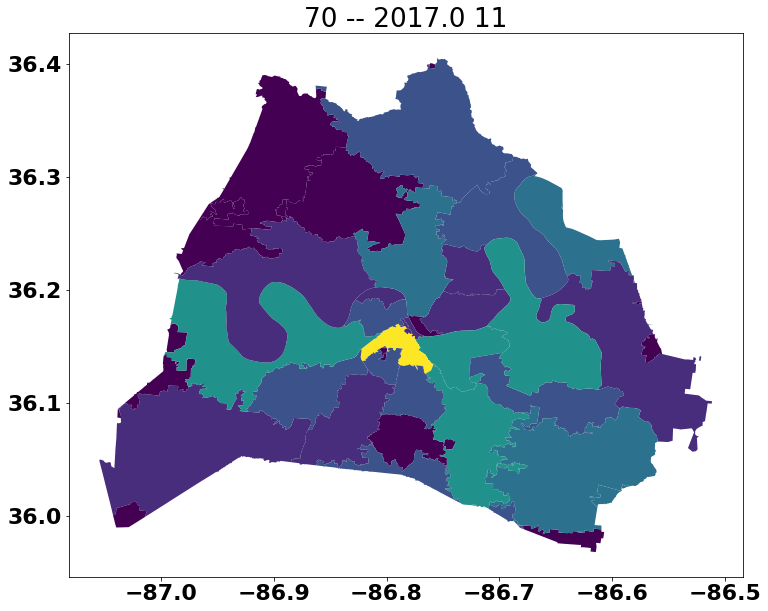

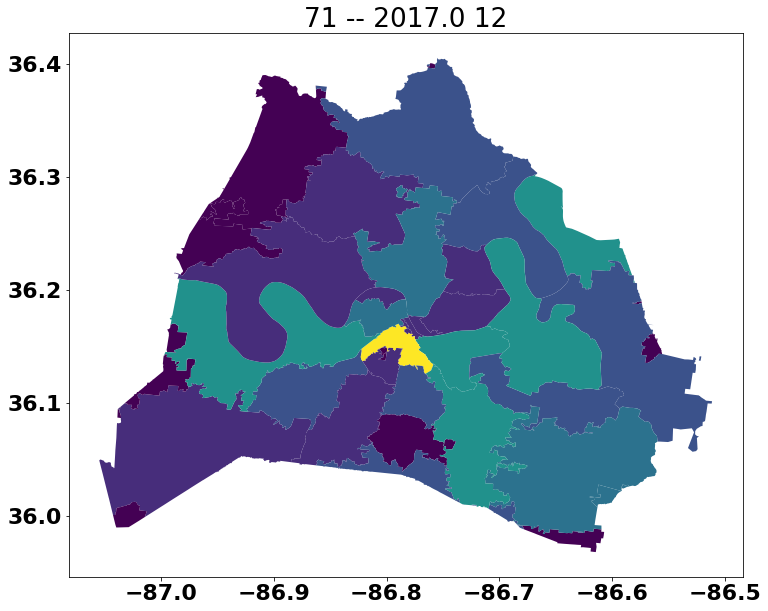

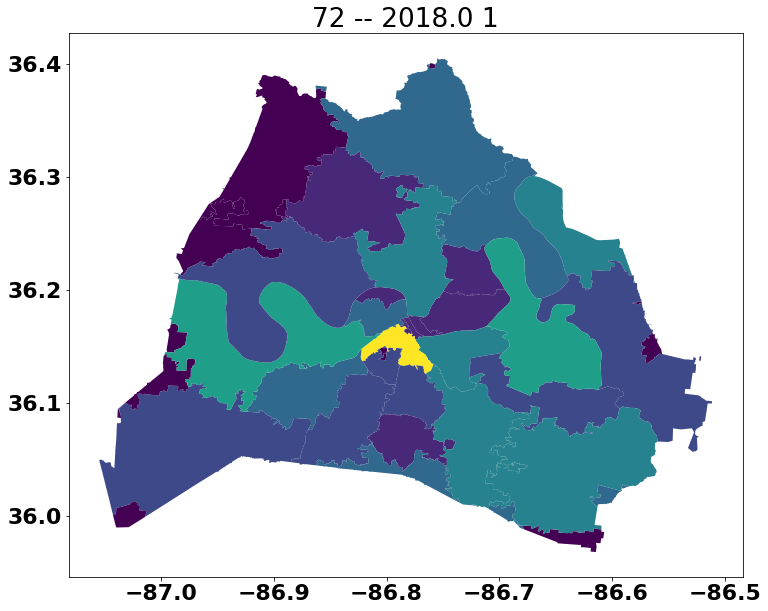

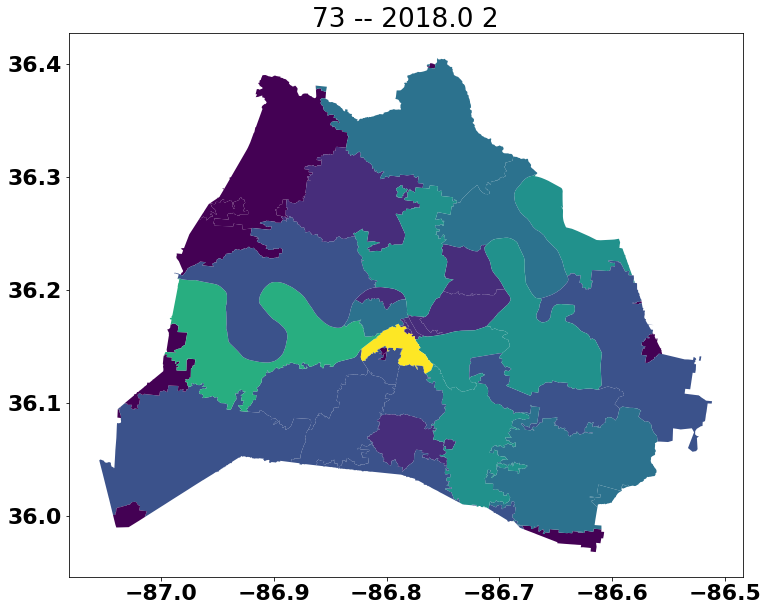

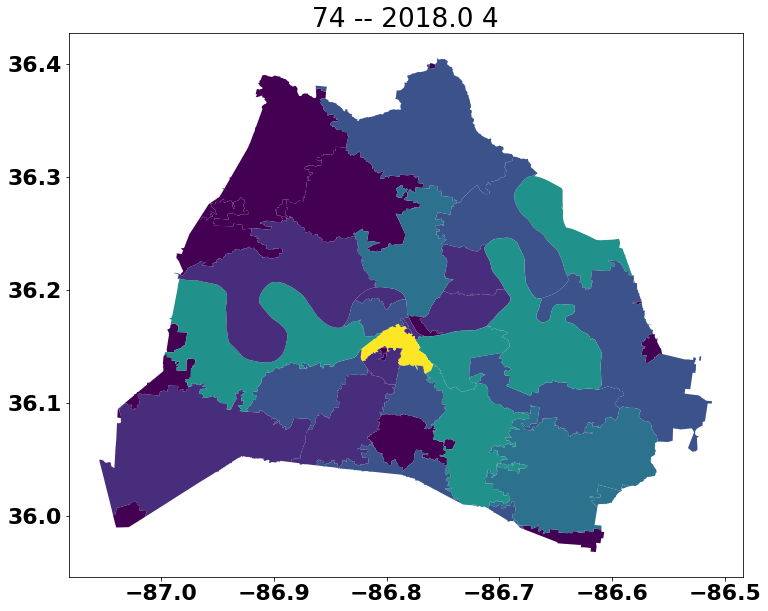

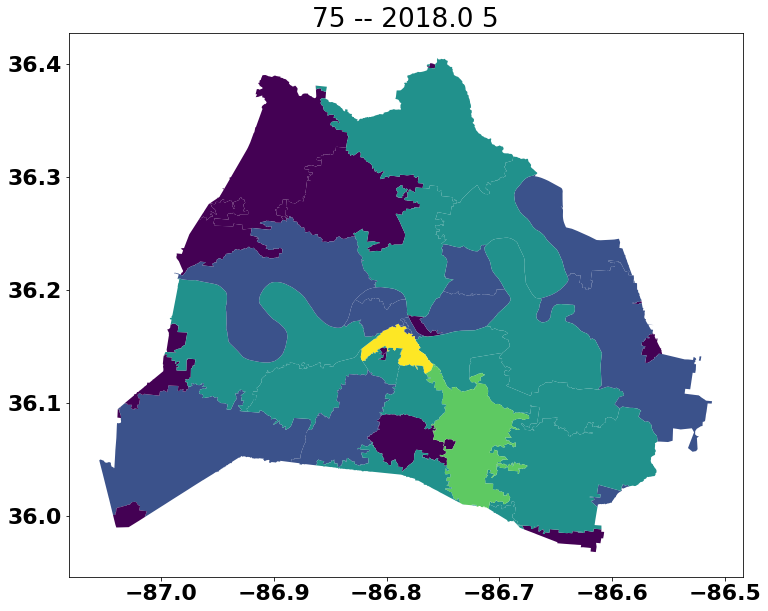

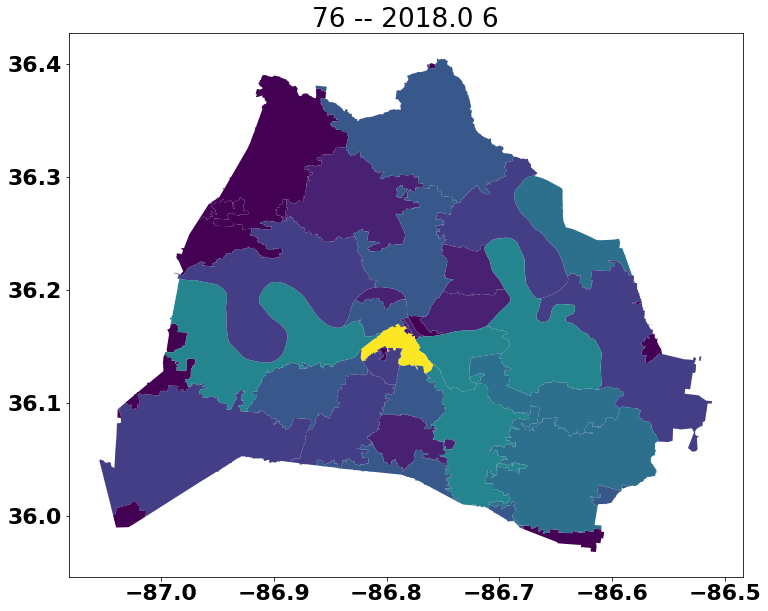

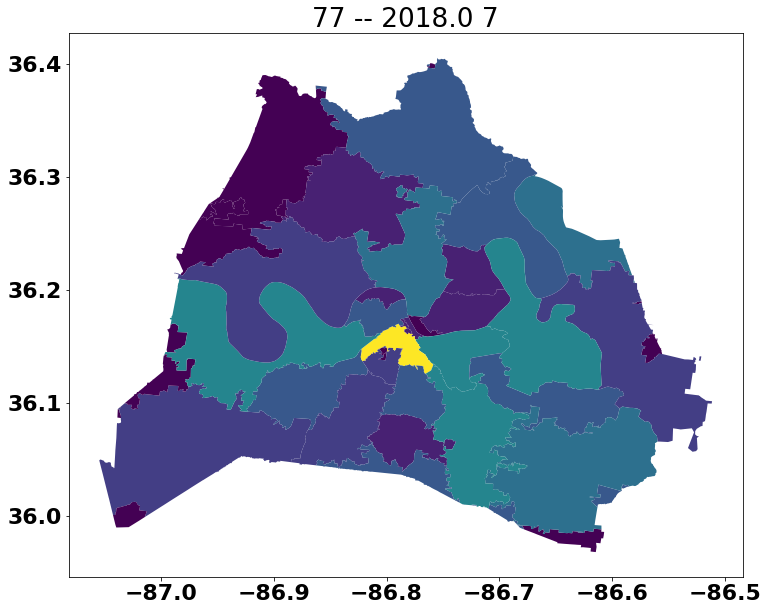

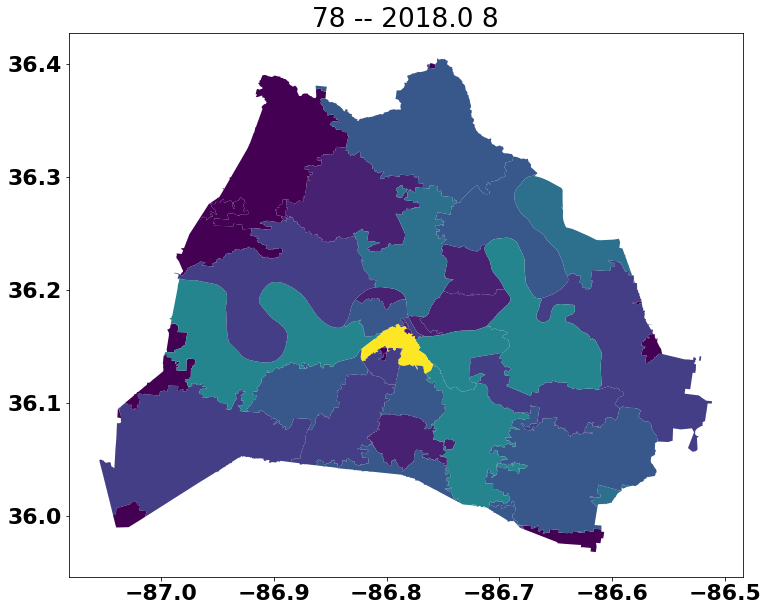

In [59]:
for ind, ((year, month), df) in enumerate(monthly_useage.groupby(['year', 'month'])):
    print(ind, year, month)
    zip_codes_gpd['monthly_kwh_used'] = zip_codes_gpd.zip.apply(
        lambda x: get_sum(x, df, max_val)
    )

    zip_codes_gpd.plot(
        column='monthly_kwh_used',
        figsize=(20, 10)
    )
    
    plt.title(f'{ind} -- {year} {month}')
    
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

    plt.rc('font', **font)

    plt.savefig(f'./../images/{ind}__{year}_{month}_nes.png');